# FOODLAB PROJECT

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import json

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## I - Turning File into Parquet

In [14]:
# Define all columns to import
cols_to_import = [
    'product_name',
    'quantity',
    'packaging',
    'packaging_tags',
    'packaging_en',
    'origins',
    'categories',
    'pnns_groups_1',
    'pnns_groups_2',
    'main_category_en',
    'brand_owner',
    'origins_tags',
    'origins_en',
    'countries',
    'nutriscore_score',
    'nutriscore_grade',
    'food_groups',
    'ecoscore_score',
    'ecoscore_grade',
    'popularity_tags',
    'energy-kj_100g',
    'energy-kcal_100g',
    'energy_100g',
    'saturated-fat_100g',
    'cholesterol_100g',
    'carbon-footprint_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g'
]

chunk_size = 5000  

# Initialize Parquet writer and schema
parquet_writer = None
schema = None

# Define the converter function for 'nutriscore_score'
def safe_float_convert(x):
    try:
        return float(x)
    except ValueError:
        return pd.NA  # Use pandas.NA for missing values in float columns

# Apply the converter to 'nutriscore_score'
converters = {'nutriscore_score': safe_float_convert}

# Note: If other columns also require special handling, add them to the converters dictionary in a similar manner

for chunk in pd.read_csv("../02 - Data/openfoodfacts.csv", chunksize=chunk_size, sep='\t', usecols=cols_to_import, converters=converters):
    # Explicitly convert 'origins' to string to avoid type mismatches
    chunk['origins'] = chunk['origins'].astype(str)
    
    # Convert the chunk to a PyArrow Table
    table = pa.Table.from_pandas(chunk, schema=schema, preserve_index=False)
    
    # Initialize schema from the first chunk and initialize writer
    if schema is None:
        schema = table.schema
        parquet_writer = pq.ParquetWriter("../02 - Data/openfoodfact_full2.parquet", schema, version='2.0')
    
    # Write the table (chunk) to the Parquet file
    parquet_writer.write_table(table)

# Close the Parquet writer
if parquet_writer:
    parquet_writer.close()


/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/214577753.py:65: FutureWarning: Parquet format '2.0' pseudo version is deprecated, use '2.4' or '2.6' for fine-grained feature selection
  parquet_writer = pq.ParquetWriter("../02 - Data/openfoodfact_full2.parquet", schema, version='2.0')
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/214577753.py:55: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("../02 - Data/openfoodfacts.csv", chunksize=chunk_size, sep='\t', usecols=cols_to_import, converters=converters):
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/214577753.py:55: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("../02 - Data/openfoodfacts.csv", chunksize=chunk_size, sep='\t', usecols=cols_to_import, converters=converters):
/var/folders/2f/9dkfxmjx077_hs31d2c5

## II - Creating the countries dictionnary

In [ ]:
country_mapping = {
    "ad": "Andorra",
    "ae": "United Arab Emirates",
    "af": "Afghanistan",
    "afghanistan": "Afghanistan",
    "africa de sud": "South Africa",
    "afrique du sud": "South Africa",
    "ag": "Antigua and Barbuda",
    "ahvenanmaan maakunta": "\u00c5land Islands",
    "al": "Albania",
    "aland-islands": "\u00c5land Islands",
    "alankomaat": "Netherlands",
    "albania": "Albania",
    "albanie": "Albania",
    "albanien": "Albania",
    "albanija": "Albania",
    "alb\u00e1nie": "Albania",
    "alb\u00e2nia": "Albania",
    "alemanha": "Germany",
    "alemania": "Germany",
    "algeria": "Algeria",
    "algerie": "Algeria",
    "algerien": "Algeria",
    "algieria": "Algeria",
    "alg\u00e9rie": "Algeria",
    "allemagne": "Germany",
    "almanya": "Germany",
    "am": "Armenia",
    "america": "United States",
    "american samoa": "American Samoa",
    "amerika birle\u015fik devletleri": "United States",
    "amerika syarikat": "United States",
    "amerikai egyes\u00fclt \u00e1llamok": "United States",
    "ameriketako estatu batuak": "United States",
    "an fhraing": "France",
    "an r\u00ecoghachd aonaichte": "United Kingdom",
    "andora": "Andorra",
    "andorra": "Andorra",
    "andorre": "Andorra",
    "angle": "England",
    "angleterre": "England",
    "angola": "Angola",
    "anguilla": "Anguilla",
    "ar": "Argentina",
    "ar:ar:algeria": "Algeria",
    "ar:france": "France",
    "arab saudi": "Saudi Arabia",
    "arabia saudita": "Saudi Arabia",
    "arabia saudit\u0103": "Saudi Arabia",
    "arabia saudyjska": "Saudi Arabia",
    "arabie saoudite": "Saudi Arabia",
    "argelia": "Algeria",
    "argentina": "Argentina",
    "argentina-espanol": "Argentina",
    "argentine": "Argentina",
    "argentinien": "Argentina",
    "argentyna": "Argentina",
    "arg\u00e9lia": "Algeria",
    "armenia": "Armenia",
    "armenia-py\u0441\u0441\u043a\u0438\u0439": "Armenia",
    "arm\u00e9nie": "Armenia",
    "aruba": "Aruba",
    "aruba-espanol": "Aruba",
    "ar\u00e1bia saudita": "Saudi Arabia",
    "as": "American Samoa",
    "asia-pacific": "Asia-Pacific",
    "at": "Austria",
    "au": "Australia",
    "australia": "Australia",
    "australia-english": "Australia",
    "australie": "Australia",
    "australien": "Australia",
    "australija": "Australia",
    "australi\u00eb": "Australia",
    "austria": "Austria",
    "austria-deutsch": "Austria",
    "austrija": "Austria",
    "austr\u00e1lia": "Australia",
    "austr\u00e1lie": "Australia",
    "ausztria": "Austria",
    "ausztr\u00e1lia": "Australia",
    "autriche": "Austria",
    "autr\u00e1lia": "Australia",
    "avstralija": "Australia",
    "avstrija": "Austria",
    "aw": "Aruba",
    "azerbaijan": "Azerbaijan",
    "azerbaijan-\u0440\u0443\u0441\u0441\u043a\u0438\u0439": "Azerbaijan",
    "azerba\u00efdjan": "Azerbaijan",
    "az\u0259rbaycan": "Azerbaijan",
    "ba": "Bosnia and Herzegovina",
    "bahamas": "Bahamas",
    "bahrain": "Bahrain",
    "bahre\u00efn": "Bahrain",
    "bangladesh": "Bangladesh",
    "banglad\u00e9s": "Bangladesh",
    "barbados": "Barbados",
    "bar\u00e9in": "Bahrain",
    "bb": "Barbados",
    "bd": "Bangladesh",
    "be": "Belgium",
    "belanda": "Netherlands",
    "belarus": "Belarus",
    "belarus-py\u0441\u0441\u043a\u0438\u0439": "Belarus",
    "belgia": "Belgium",
    "belgica": "Belgium",
    "belgicko": "Belgium",
    "belgie": "Belgium",
    "belgien": "Belgium",
    "belgija": "Belgium",
    "belgio": "Belgium",
    "belgique": "Belgium",
    "belgium": "Belgium",
    "belgium-francais": "Belgium",
    "belgium-nederlands": "Belgium",
    "belgi\u00eb": "Belgium",
    "bel\u00e7ika": "Belgium",
    "benelux": "Benelux",
    "benin": "Benin",
    "ben\u00edn": "Benin",
    "bermuda": "Bermuda",
    "beyaz rusya": "Belarus",
    "bg": "Bulgaria",
    "bg::bulgaria": "Bulgaria",
    "bg:canada": "Canada",
    "bg:en:bulgaria": "Bulgaria",
    "bg:\u0431\u044a\u043b\u0433\u0430\u0440\u0438\u044f": "Bulgaria",
    "bh": "Bahrain",
    "bhoutan": "Bhutan",
    "bhutan": "Bhutan",
    "bia\u0142oru\u015b": "Belarus",
    "bielorrusia": "Belarus",
    "birle\u015fik krall\u0131k": "United Kingdom",
    "birmania": "Myanmar",
    "bi\u00e9lorussie": "Belarus",
    "bj": "Benin",
    "bm": "Bermuda",
    "bn": "Brunei",
    "bo": "Bolivia",
    "bolivia": "Bolivia",
    "bolivia-espanol": "Bolivia",
    "bolivie": "Bolivia",
    "bolivien": "Bolivia",
    "bosna a hercegovina": "Bosnia and Herzegovina",
    "bosna i hercegovina": "Bosnia and Herzegovina",
    "bosna in hercegovina": "Bosnia and Herzegovina",
    "bosnia": "Bosnia and Herzegovina",
    "bosnia and herzegovina": "Bosnia and Herzegovina",
    "bosnia y herzegovina": "Bosnia and Herzegovina",
    "bosnia-and-herzegovina": "Bosnia and Herzegovina",
    "bosnia-i-hercegovina-bosnian": "Bosnia and Herzegovina",
    "bosnie-herz\u00e9govine": "Bosnia and Herzegovina",
    "bosnien und herzegowina": "Bosnia and Herzegovina",
    "bosznia-hercegovina": "Bosnia and Herzegovina",
    "botswana": "Botswana",
    "botswana-english": "Botswana",
    "bo\u015bnia i hercegowina": "Bosnia and Herzegovina",
    "bq": "Bonaire, Saint Eustatius and Saba",
    "br": "Brazil",
    "brasil": "Brazil",
    "brasilien": "Brazil",
    "brazil": "Brazil",
    "brazil  en:france": "Brazil",
    "brazil-portugues": "Brazil",
    "brazylia": "Brazil",
    "british indian ocean territory": "British Indian Ocean Territory",
    "brunei": "Brunei",
    "br\u00e9sil": "Brazil",
    "bs": "Bahamas",
    "bugarska": "Bulgaria",
    "bulgaaria": "Bulgaria",
    "bulgaria": "Bulgaria",
    "bulgaria-\u0431\u044a\u043b\u0433\u0430\u0440\u0441\u043a\u0438": "Bulgaria",
    "bulgarie": "Bulgaria",
    "bulgarien": "Bulgaria",
    "bulgarija": "Bulgaria",
    "bulgarije": "Bulgaria",
    "bulg\u00e1ria": "Bulgaria",
    "bulg\u0101rija": "Bulgaria",
    "bulharsko": "Bulgaria",
    "burkina faso": "Burkina Faso",
    "burundi": "Burundi",
    "bu\u0142garia": "Bulgaria",
    "by": "Belarus",
    "b\u00e8lgica": "Belgium",
    "b\u00e9lgica": "Belgium",
    "b\u00e9nin": "Benin",
    "ca": "Canada",
    "ca:franca": "Canada",
    "ca:fran\u00e7a": "Canada",
    "cabo verde": "Cape Verde",
    "cambodge": "Cambodia",
    "cambodia": "Cambodia",
    "cambodia-english": "Cambodia",
    "cambodia-\u1797\u17b6\u179f\u17b6\u1781\u17d2\u1798\u17c2\u179a": "Cambodia",
    "cambogia": "Cambodia",
    "cameroon": "Cameroon",
    "cameroun": "Cameroon",
    "canada": "Canada",
    "canada-english": "Canada",
    "canada-francais": "Canada",
    "canad\u00e0": "Canada",
    "canad\u00e1": "Canada",
    "cantabria": "Cantabria",
    "cap-vert": "Cape Verde",
    "cape verde": "Cape Verde",
    "caribbean netherlands": "Caribbean Netherlands",
    "cayman islands": "Cayman Islands",
    "cd": "Democratic Republic of the Congo",
    "cehia": "Czech Republic",
    "cezayir": "Algeria",
    "cg": "Congo",
    "ch": "Switzerland",
    "chile": "Chile",
    "chile-espanol": "Chile",
    "chili": "Chile",
    "china": "China",
    "china-\u4e2d\u6587": "China",
    "chine": "China",
    "chipre": "Cyprus",
    "chi\u0144ska republika ludowa": "China",
    "chorvatsko": "Croatia",
    "chorv\u00e1tsko": "Croatia",
    "chorwacja": "Croatia",
    "chypre": "Cyprus",
    "ci": "Ivory Coast",
    "cile": "Chile",
    "cina": "China",
    "cipar": "Cyprus",
    "cipro": "Cyprus",
    "cl": "Chile",
    "cm": "Cameroon",
    "cn": "China",
    "co": "Colombia",
    "cocoa horizons": "Cocoa Horizons Foundation",
    "colombia": "Colombia",
    "colombia-espanol": "Colombia",
    "colombie": "Colombia",
    "comoros": "Comoros",
    "congo": "Congo",
    "corea del sur": "South Korea",
    "coreea de sud": "South Korea",
    "coreia do sul": "South Korea",
    "cor\u00e9e du sud": "South Korea",
    "costa d'avorio": "Ivory Coast",
    "costa de marfil": "Ivory Coast",
    "costa do marfim": "Ivory Coast",
    "costa rica": "Costa Rica",
    "costa-rica": "Costa Rica",
    "costa-rica-espanol": "Costa Rica",
    "cote-d-ivoire": "Ivory Coast",
    "cr": "Costa Rica",
    "crna gora": "Montenegro",
    "croacia": "Croatia",
    "croatia": "Croatia",
    "croatia-hrvatski": "Croatia",
    "croatie": "Croatia",
    "croazia": "Croatia",
    "cro\u00e1cia": "Croatia",
    "csehorsz\u00e1g": "Czech Republic",
    "cu": "Cuba",
    "cuba": "Cuba",
    "curazao": "Cura\u00e7ao",
    "cura\u00e7ao": "Cura\u00e7ao",
    "cv": "Cape Verde",
    "cw": "Cura\u00e7ao",
    "cy": "Cyprus",
    "cypr": "Cyprus",
    "cyprus": "Cyprus",
    "cyprus-\u03b5\u03bb\u03bb\u03b7\u03bd\u03b9\u03ba\u03ac": "Cyprus",
    "cz": "Czech Republic",
    "czech republic": "Czech Republic",
    "czech-republic": "Czech Republic",
    "czech-republic-\u010de\u0161tina": "Czech Republic",
    "czechia": "Czech Republic",
    "czechy": "Czech Republic",
    "c\u00f4te d'ivoire": "Ivory Coast",
    "danemark": "Denmark",
    "dania": "Denmark",
    "danimarca": "Denmark",
    "danmark": "Denmark",
    "danska": "Denmark",
    "de": "Germany",
    "de:amsterdam": "Amsterdam",
    "de:deutschland": "Germany",
    "de:en:de": "Germany",
    "de:en:germany": "Germany",
    "de:europ\u00e4ische union": "European Union",
    "de:germany": "Germany",
    "de:italien": "Italy",
    "de:schweden": "Sweden",
    "de:schweiz": "Switzerland",
    "de:t\u00fcrkei": "Turkey",
    "de:vereinigtes k\u00f6nigreich": "United Kingdom",
    "de:\u00f6sterreich": "Austria",
    "democratic republic of the congo": "Democratic Republic of the Congo",
    "democratic-republic-of-the-congo": "Democratic Republic of the Congo",
    "denemarken": "Denmark",
    "denmark": "Denmark",
    "denmark-dansk": "Denmark",
    "deutsche demokratische republik": "German Democratic Republic",
    "deutschland": "Germany",
    "dinamarca": "Denmark",
    "dj": "Djibouti",
    "djibouti": "Djibouti",
    "dk": "Denmark",
    "dm": "Dominica",
    "do": "Dominican Republic",
    "dom tom": "French Overseas Territories",
    "dom-tom": "French Overseas Territories",
    "dominica": "Dominica",
    "dominican republic": "Dominican Republic",
    "dr congo": "Democratic Republic of the Congo",
    "duitsland": "Germany",
    "dz": "Algeria",
    "d\u00e1nm\u00e1rku": "Denmark",
    "d\u00e1nsko": "Denmark",
    "d\u00e4nemark": "Denmark",
    "d\u00e9l-korea": "South Korea",
    "east germany": "East Germany",
    "east-germany": "East Germany",
    "ec": "Ecuador",
    "ecuador": "Ecuador",
    "ecuador-espanol": "Ecuador",
    "ee": "Estonia",
    "eesti": "Estonia",
    "eg": "Egypt",
    "egipt": "Egypt",
    "egito": "Egypt",
    "egitto": "Egypt",
    "egypt": "Egypt",
    "el salvador": "El Salvador",
    "el-salvador": "El Salvador",
    "el-salvador-espanol": "El Salvador",
    "elfenbeink\u00fcste": "Ivory Coast",
    "elve\u021bia": "Switzerland",
    "emiratele arabe unite": "United Arab Emirates",
    "emirati arabi uniti": "United Arab Emirates",
    "emiratos \u00e1rabes unidos": "United Arab Emirates",
    "en": "England",
    "en:au": "Australia",
    "en:australia": "Australia",
    "en:be": "Belgium",
    "en:bulgaria": "Bulgaria",
    "en:ca": "Canada",
    "en:en:us": "United States",
    "en:francia": "France",
    "en:gb": "United Kingdom",
    "en:germany": "Germany",
    "en:ie": "Ireland",
    "en:italy": "Italy",
    "en:ukraine": "Ukraine",
    "en:united kingdom": "United Kingdom",
    "en:united states": "United States",
    "en:us": "United States",
    "england": "England",
    "es": "Spain",
    "es:am\u00e9rica": "America",
    "es:ar:espa\u00f1a": "Spain",
    "es:argentina": "Argentina",
    "es:cantabria": "Cantabria",
    "es:costa rica": "Costa Rica",
    "es:en:es": "Spain",
    "es:en:mexico": "Mexico",
    "es:en:spain": "Spain",
    "es:es:espa\u00f1a": "Spain",
    "es:es:spain": "Spain",
    "es:espa\u00f1a": "Spain",
    "es:france": "France",
    "es:francia": "France",
    "es:italia": "Italy",
    "es:m\u00e9xico": "Mexico",
    "es:paraguay": "Paraguay",
    "es:per\u00fa": "Peru",
    "es:portugal": "Portugal",
    "es:santona": "Santo\u00f1a",
    "es:santo\u00f1a": "Santo\u00f1a",
    "es:spain": "Spain",
    "eslovaquia": "Slovakia",
    "eslovenia": "Slovenia",
    "eslov\u00e1quia": "Slovakia",
    "eslov\u00e9nia": "Slovenia",
    "espagne": "Spain",
    "espainia": "Spain",
    "espanha": "Spain",
    "espanja": "Spain",
    "espanya": "Spain",
    "espa\u00f1a": "Spain",
    "estados unidos": "United States",
    "estija": "Estonia",
    "estland": "Estonia",
    "estonia": "Estonia",
    "estonia-eesti": "Estonia",
    "estonie": "Estonia",
    "estonija": "Estonia",
    "estonsko": "Estonia",
    "est\u00f3nia": "Estonia",
    "est\u00f3nsko": "Estonia",
    "et": "Ethiopia",
    "et:eesti": "Estonia",
    "et:gruusia": "Georgia",
    "et:leedu": "Lithuania",
    "ethiopia": "Ethiopia",
    "eu": "European Union",
    "europe": "Europe",
    "european union": "European Union",
    "european-union": "European Union",
    "europese unie": "European Union",
    "europ\u00e4ische union": "European Union",
    "evropska unija": "European Union",
    "evropsk\u00e1 unie": "European Union",
    "faroe islands": "Faroe Islands",
    "fas": "Morocco",
    "fi": "Finland",
    "fi:suomi": "Finland",
    "fiji": "Fiji",
    "filipinas": "Philippines",
    "filipiny": "Philippines",
    "finland": "Finland",
    "finland-suomi": "Finland",
    "finlanda": "Finland",
    "finlande": "Finland",
    "finlandia": "Finland",
    "finl\u00e2ndia": "Finland",
    "finnland": "Finland",
    "finska": "Finland",
    "finsko": "Finland",
    "fj": "Fiji",
    "fo": "Faroe Islands",
    "fr": "France",
    "fr:alg\u00e9rie": "Algeria",
    "fr:allemagne": "Germany",
    "fr:australie": "Australia",
    "fr:autriche": "Austria",
    "fr:belgica": "Belgium",
    "fr:belgien": "Belgium",
    "fr:belgique": "Belgium",
    "fr:belgium": "Belgium",
    "fr:b\u00e9lgica": "Belgium",
    "fr:canada": "Canada",
    "fr:cor\u00e9e du sud": "South Korea",
    "fr:deutschland": "Germany",
    "fr:dom tom": "French Overseas Territories",
    "fr:dom-tom": "French Overseas Territories",
    "fr:duitsland": "Germany",
    "fr:en:ar": "Argentina",
    "fr:en:be": "Belgium",
    "fr:en:ca": "Canada",
    "fr:en:ch": "Switzerland",
    "fr:en:fr": "France",
    "fr:en:france": "France",
    "fr:en:ly": "Libya",
    "fr:en:ro": "Romania",
    "fr:en:us": "United States",
    "fr:espagne": "Spain",
    "fr:fr:en:fr": "France",
    "fr:fr:frankreich": "Germany",
    "fr:france": "France",
    "fr:francia": "France",
    "fr:frankreich": "Germany",
    "fr:frankrijk": "Netherlands",
    "fr:gr\u00e8ce": "Greece",
    "fr:italie": "Italy",
    "fr:la r\u00e9union": "R\u00e9union",
    "fr:liban": "Lebanon",
    "fr:lux": "Luxembourg",
    "fr:luxembourg": "Luxembourg",
    "fr:mac\u00e9doine du nord": "North Macedonia",
    "fr:maroc": "Morocco",
    "fr:nederland": "Netherlands",
    "fr:netherlands": "Netherlands",
    "fr:no": "Norway",
    "fr:nouvelle-cal\u00e9donie": "New Caledonia",
    "fr:nouvelle-z\u00e9lande": "New Zealand",
    "fr:pays-bas": "Netherlands",
    "fr:pologne": "Poland",
    "fr:portugal": "Portugal",
    "fr:schweiz": "Switzerland",
    "fr:suisse": "Switzerland",
    "fr:suiza": "Switzerland",
    "fr:tunisie": "Tunisia",
    "fr:turquie": "Turkey",
    "fr:union europ\u00e9enne": "European Union",
    "fr:zuid-afrika": "South Africa",
    "fr:\u00e9mirats arabes unis": "United Arab Emirates",
    "fra": "France",
    "frakland": "France",
    "france": "France",
    "france  spain": "France",
    "france  switzerland  germany": "France",
    "france-francais": "France",
    "france.": "France",
    "francia": "France",
    "francia  espa\u00f1a": "France",
    "franciaorsz\u00e1g": "France",
    "francie": "France",
    "francija": "France",
    "francja": "France",
    "francuska": "France",
    "franc\u00fazsko": "France",
    "frankreich": "Germany",
    "frankrig": "France",
    "frankriika": "France",
    "frankrijk": "Netherlands",
    "frankrike": "France",
    "fransa": "France",
    "frantzia": "France",
    "franz\u00f6sisch-guayana": "French Guiana",
    "franz\u00f6sisch-polynesien": "French Polynesia",
    "fran\u00e7a": "France",
    "fran\u021ba": "France",
    "french guiana": "French Guiana",
    "french polynesia": "French Polynesia",
    "french-guiana": "French Guiana",
    "french-polynesia": "French Polynesia",
    "f\u00e4r\u00f6er": "Faroe Islands",
    "f\u00ednsko": "Finland",
    "ga": "Gabon",
    "gabon": "Gabon",
    "galmudug": "Galmudug",
    "gb": "United Kingdom",
    "gd": "Grenada",
    "ge": "Georgia",
    "georgia": "Georgia",
    "georgia-\u10e5\u10d0\u10e0\u10d7\u10e3\u10da\u10d8": "Georgia",
    "georgien": "Georgia",
    "germania": "Germany",
    "germany": "Germany",
    "germany-deutsch": "Germany",
    "gf": "French Guiana",
    "gg": "Guernsey",
    "gh": "Ghana",
    "ghana": "Ghana",
    "ghana-english": "Ghana",
    "gi": "Gibraltar",
    "giappone": "Japan",
    "gibilterra": "Gibraltar",
    "gibraltar": "Gibraltar",
    "giordania": "Jordan",
    "gn": "Guinea",
    "gp": "Guadeloupe",
    "gq": "Equatorial Guinea",
    "gr": "Greece",
    "grecia": "Greece",
    "grecja": "Greece",
    "greece": "Greece",
    "greece-\u03b5\u03bb\u03bb\u03b7\u03bd\u03b9\u03ba\u03ac": "Greece",
    "grenada": "Grenada",
    "griechenland": "Greece",
    "griekenland": "Greece",
    "gruzja": "Georgia",
    "gr\u00e8ce": "Greece",
    "gr\u00e9cia": "Greece",
    "gr\u010dka": "Greece",
    "gt": "Guatemala",
    "gu": "Guam",
    "guadalupa": "Guadeloupe",
    "guadalupe": "Guadeloupe",
    "guadeloupe": "Guadeloupe",
    "guam": "Guam",
    "guatemala": "Guatemala",
    "guatemala-espanol": "Guatemala",
    "guayana francesa": "French Guiana",
    "guernesey": "Guernsey",
    "guernsey": "Guernsey",
    "guinea": "Guinea",
    "guinea ecuatorial": "Equatorial Guinea",
    "guin\u00e9e": "Guinea",
    "guyana": "Guyana",
    "guyane": "French Guiana",
    "gy": "Guyana",
    "g\u00e9orgie": "Georgia",
    "g\u00f6r\u00f6gorsz\u00e1g": "Greece",
    "haiti": "Haiti",
    "hait\u00ed": "Haiti",
    "hashemite kingdom of jordan": "Jordan",
    "ha\u00efti": "Haiti",
    "hispaania": "Spain",
    "hiszpania": "Spain",
    "hk": "Hong Kong",
    "hn": "Honduras",
    "holandia": "Netherlands",
    "holandsko": "Netherlands",
    "holland": "Netherlands",
    "hollande": "France",
    "honduras": "Honduras",
    "honduras-espanol": "Honduras",
    "hong kong": "Hong Kong",
    "hong-kong": "Hong Kong",
    "hong-kong-\u7cb5\u8a9e": "Hong Kong",
    "hongarije": "Hungary",
    "hongkong": "Hong Kong",
    "hongrie": "Hungary",
    "hr": "Croatia",
    "hr:hrvatska": "Croatia",
    "hrvatska": "Croatia",
    "hrva\u0161ka": "Croatia",
    "ht": "Haiti",
    "hu": "Hungary",
    "hu:magyarorsz\u00e1g": "Hungary",
    "hungary": "Hungary",
    "hungary-magyar": "Hungary",
    "hungria": "Hungary",
    "hungr\u00eda": "Hungary",
    "iceland": "Iceland",
    "iceland-islenska": "Iceland",
    "id": "Indonesia",
    "ie": "Ireland",
    "ierland": "Ireland",
    "iirimaa": "Ireland",
    "ijsland": "Iceland",
    "il": "Israel",
    "im": "Isle of Man",
    "in": "India",
    "inde": "India",
    "india": "India",
    "india-english": "India",
    "indie": "India",
    "indien": "India",
    "indonesia": "Indonesia",
    "indonesia-bahasa-indonesia": "Indonesia",
    "indonesi\u00eb": "Indonesia",
    "indonezja": "Indonesia",
    "indon\u00e9sie": "Indonesia",
    "international": "International",
    "iq": "Iraq",
    "ir": "Iran",
    "irak": "Iraq",
    "iran": "Iran",
    "iraq": "Iraq",
    "iraqi kurdistan": "Iraqi Kurdistan",
    "ireland": "Ireland",
    "ireland & uk": "Ireland",
    "ireland-english": "Ireland",
    "irland": "Ireland",
    "irlanda": "Ireland",
    "irlande": "Ireland",
    "irlandia": "Ireland",
    "irlanti": "Ireland",
    "irska": "Ireland",
    "irsko": "Ireland",
    "ir\u00e1n": "Iran",
    "is": "Iceland",
    "island": "Iceland",
    "islanda": "Iceland",
    "islande": "Iceland",
    "islandia": "Iceland",
    "islanti": "Iceland",
    "isle of man": "Isle of Man",
    "isl\u00e2ndia": "Iceland",
    "ispanija": "Spain",
    "israel": "Israel",
    "israel-\u05e2\u05d1\u05e8\u05d9\u05ea": "Israel",
    "isra\u00ebl": "Israel",
    "it": "Italy",
    "it:..": "Italy",
    "it:austria": "Austria",
    "it:cile": "Chile",
    "it:en:it": "Italy",
    "it:france": "France",
    "it:germania": "Germany",
    "it:grecia": "Greece",
    "it:it:italie": "Italy",
    "it:it:italy": "Italy",
    "it:italia": "Italy",
    "it:italy": "Italy",
    "it:polonia": "Poland",
    "it:portogallo": "Portugal",
    "it:regno unito": "United Kingdom",
    "it:spagna": "Spain",
    "italia": "Italy",
    "italie": "Italy",
    "italien": "Italy",
    "italija": "Italy",
    "itali\u00eb": "Italy",
    "italy": "Italy",
    "italy-italiano": "Italy",
    "it\u00e0lia": "Italy",
    "it\u00e1lia": "Italy",
    "it\u00e1lie": "Italy",
    "it\u00e4valta": "Austria",
    "ivory coast": "Ivory Coast",
    "izrael": "Israel",
    "izraelis": "Israel",
    "i\u0307spanya": "Spain",
    "i\u0307svi\u00e7re": "Switzerland",
    "jamaica": "Jamaica",
    "jamaica-english": "Jamaica",
    "jama\u00efque": "Jamaica",
    "japan": "Japan",
    "japan-\u65e5\u672c\u8a9e": "Japan",
    "japani": "Japan",
    "japon": "Japan",
    "japonia": "Japan",
    "japonija": "Japan",
    "jap\u00f3n": "Japan",
    "jap\u0101na": "Japan",
    "je": "Jersey",
    "jersey": "Jersey",
    "jm": "Jamaica",
    "jo": "Jordan",
    "jordan": "Jordan",
    "jordania": "Jordan",
    "jordanie": "Jordan",
    "jordanien": "Jordan",
    "jp": "Japan",
    "jugoslavija": "Yugoslavia",
    "jungtiniai arab\u0173 emyratai": "United Arab Emirates",
    "jungtin\u0117 karalyst\u0117": "United Kingdom",
    "jungtin\u0117s amerikos valstijos": "United States",
    "kambodscha": "Cambodia",
    "kamerun": "Cameroon",
    "kanada": "Canada",
    "kasachstan": "Kazakhstan",
    "katar": "Qatar",
    "kazachstan": "Kazakhstan",
    "kazakhstan": "Kazakhstan",
    "kazakhstan-py\u0441\u0441\u043a\u0438\u0439": "Kazakhstan",
    "ke": "Kenya",
    "kenya": "Kenya",
    "kh": "Cambodia",
    "kina": "China",
    "kirgisistan": "Kyrgyzstan",
    "km": "Comoros",
    "kolumbia": "Colombia",
    "kolumbien": "Colombia",
    "korea selatan": "South Korea",
    "korea-\ud55c\uad6d\uc5b4": "South Korea",
    "kosovo": "Kosovo",
    "kowe\u00eft": "Kuwait",
    "kr": "South Korea",
    "kroatia": "Croatia",
    "kroatien": "Croatia",
    "kroati\u00eb": "Croatia",
    "kuvajt": "Kuwait",
    "kuwait": "Kuwait",
    "kuwejt": "Kuwait",
    "kw": "Kuwait",
    "kyrgyzstan": "Kyrgyzstan",
    "kyrgyzstan-\u0440\u0443\u0441\u0441\u043a\u0438\u0439": "Kyrgyzstan",
    "k\u0131br\u0131s cumhuriyeti": "Republic of Cyprus",
    "la": "Laos",
    "la r\u00e9union": "R\u00e9union",
    "la-reunion": "R\u00e9union",
    "laos": "Laos",
    "latvia": "Latvia",
    "latvia-latvie\u0161u": "Latvia",
    "latvija": "Latvia",
    "lb": "Lebanon",
    "lc": "Saint Lucia",
    "lebanon": "Lebanon",
    "lebanon-english": "Lebanon",
    "lengyelorsz\u00e1g": "Hungary",
    "lenkija": "Lithuania",
    "lesotho-english": "Lesotho",
    "letland": "Latvia",
    "letonia": "Latvia",
    "lettland": "Latvia",
    "lettonie": "Latvia",
    "let\u00f3nia": "Latvia",
    "li": "Liechtenstein",
    "liban": "Lebanon",
    "libano": "Lebanon",
    "libanon": "Lebanon",
    "libia": "Libya",
    "libya": "Libya",
    "libye": "Libya",
    "liechtenstein": "Liechtenstein",
    "liettua": "Lithuania",
    "lietuva": "Lithuania",
    "litauen": "Lithuania",
    "lithuania": "Lithuania",
    "lithuania-lietuvi\u0173": "Lithuania",
    "litouwen": "Lithuania",
    "lituania": "Lithuania",
    "lituanie": "Lithuania",
    "litu\u00e2nia": "Lithuania",
    "litva": "Lithuania",
    "litv\u00e1nia": "Lithuania",
    "litwa": "Lithuania",
    "loty\u0161sko": "Latvia",
    "lr": "Liberia",
    "lt": "Lithuania",
    "lt:bulgarija": "Bulgaria",
    "lt:estija": "Estonia",
    "lt:latvija": "Latvia",
    "lt:lenkija": "Lithuania",
    "lt:lietuva": "Lithuania",
    "lu": "Luxembourg",
    "lucembursko": "Luxembourg",
    "luksemburg": "Luxembourg",
    "lussemburgo": "Luxembourg",
    "luxembourg": "Luxembourg",
    "luxemburg": "Luxembourg",
    "luxenburgo": "Luxembourg",
    "lv": "Latvia",
    "ly": "Libya",
    "l\u00ebtzebuerg (land)": "Luxembourg",
    "l\u00edbano": "Lebanon",
    "l\u00edbia": "Libya",
    "ma": "Morocco",
    "macao": "Macau",
    "macau": "Macau",
    "macau-\u4e2d\u6587": "Macau",
    "macedonia": "North Macedonia",
    "macedonia del norte": "North Macedonia",
    "mac\u00e9doine du nord": "North Macedonia",
    "madagascar": "Madagascar",
    "made in the u k (ni)": "United Kingdom (Northern Ireland)",
    "mad\u017earska": "Hungary",
    "magyarorsz\u00e1g": "Hungary",
    "malaisie": "Malaysia",
    "malasia": "Malaysia",
    "malaysia": "Malaysia",
    "malaysia-bahasa-melayu": "Malaysia",
    "malaysia-english": "Malaysia",
    "malaysia-\u4e2d\u6587": "Malaysia",
    "maldives": "Maldives",
    "malezja": "Malaysia",
    "mali": "Mali",
    "malta": "Malta",
    "malte": "Malta",
    "mannin": "Isle of Man",
    "maroc": "Morocco",
    "marocco": "Morocco",
    "marokko": "Morocco",
    "marokk\u00f3": "Morocco",
    "maroko": "Morocco",
    "marrocos": "Morocco",
    "marruecos": "Morocco",
    "martinica": "Martinique",
    "martinik": "Martinique",
    "martinique": "Martinique",
    "maurice": "Mauritius",
    "mauricio": "Mauritius",
    "mauritania": "Mauritania",
    "mauritanie": "Mauritania",
    "mauritius": "Mauritius",
    "maur\u00edcia": "Mauritius",
    "mayotte": "Mayotte",
    "ma\u010farsko": "Hungary",
    "ma\u0111arska": "Hungary",
    "mc": "Monaco",
    "md": "Moldova",
    "me": "Montenegro",
    "meksiko": "Mexico",
    "meksyk": "Mexico",
    "messico": "Mexico",
    "mexico": "Mexico",
    "mexico-espanol": "Mexico",
    "mexiko": "Mexico",
    "mexique": "Mexico",
    "mf": "Saint Martin",
    "mg": "Madagascar",
    "middle east": "Middle East",
    "middle-east-africa": "Middle East and Africa",
    "mk": "North Macedonia",
    "ml": "Mali",
    "mm": "Myanmar",
    "mo": "Macau",
    "moldavia": "Moldova",
    "moldavie": "Moldova",
    "moldavi\u00eb": "Moldova",
    "moldavsko": "Moldova",
    "moldawien": "Moldova",
    "moldova": "Moldova",
    "moldova-roman": "Moldova",
    "monaco": "Monaco",
    "monde": "World",
    "mongolei": "Mongolia",
    "mongolia": "Mongolia",
    "mongolia-\u043c\u043e\u043d\u0433\u043e\u043b-\u0445\u044d\u043b": "Mongolia",
    "mongolie": "Mongolia",
    "montenegro": "Montenegro",
    "mont\u00e9n\u00e9gro": "Montenegro",
    "morocco": "Morocco",
    "mozambique": "Mozambique",
    "mo\u00e7ambique": "Mozambique",
    "mo\u0142dawia": "Moldova",
    "mq": "Martinique",
    "mr": "Mauritania",
    "mt": "Malta",
    "mu": "Mauritius",
    "mundo": "World",
    "mv": "Maldives",
    "mx": "Mexico",
    "my": "Malaysia",
    "myanmar": "Myanmar",
    "mz": "Mozambique",
    "m\u00e9xico": "Mexico",
    "m\u00e9xico  espa\u00f1a": "Mexico",
    "m\u00f3naco": "Monaco",
    "m\u0155xico": "Mexico",
    "na": "Namibia",
    "na st\u00e0itean aonaichte": "United States",
    "nagy-britannia": "United Kingdom",
    "namibia": "Namibia",
    "namibia-english": "Namibia",
    "nb:eu": "European Union",
    "nb:sverige": "Sweden",
    "nc": "New Caledonia",
    "ne": "Niger",
    "nederland": "Netherlands",
    "nederl\u00e2n": "Netherlands",
    "nederl\u00e4nderna": "Netherlands",
    "nemecko": "Germany",
    "nem\u010dija": "Slovenia",
    "nepal": "Nepal",
    "netherlands": "Netherlands",
    "netherlands  en:france": "Netherlands",
    "netherlands-nederlands": "Netherlands",
    "neukaledonien": "New Caledonia",
    "neuseeland": "New Zealand",
    "new caledonia": "New Caledonia",
    "new z": "New Zealand",
    "new zealand": "New Zealand",
    "new-caledonia": "New Caledonia",
    "new-zealand": "New Zealand",
    "new-zealand-english": "New Zealand",
    "ng": "Nigeria",
    "nicaragua": "Nicaragua",
    "nicaragua-espanol": "Nicaragua",
    "niederlande": "Netherlands",
    "niemcy": "Germany",
    "nieuw-caledoni\u00eb": "New Caledonia",
    "nieuw-zeeland": "New Zealand",
    "niger": "Niger",
    "nigeria": "Nigeria",
    "nizozemska": "Netherlands",
    "nizozemsko": "Netherlands",
    "njema\u010dka": "Germany",
    "nl": "Netherlands",
    "nl:belgie": "Belgium",
    "nl:belgi\u00eb": "Belgium",
    "nl:en:be": "Belgium",
    "nl:france": "France",
    "nl:frankrijk": "Netherlands",
    "nl:moldavie": "Moldova",
    "nl:nederland": "Netherlands",
    "nl:portugal": "Portugal",
    "nl:roemenie": "Romania",
    "no": "Norway",
    "noorwegen": "Norway",
    "nordmazedonien": "North Macedonia",
    "norge": "Norway",
    "norja": "Norway",
    "norsko": "Norway",
    "north korea": "North Korea",
    "north macedonia": "North Macedonia",
    "north-macedonia": "North Macedonia",
    "north-macedonia-\u043c\u0430\u043a\u0435\u0434\u043e\u043d\u0441\u043a\u0438-\u0458\u0430\u0437\u0438\u043a": "North Macedonia",
    "noruega": "Norway",
    "norvegia": "Norway",
    "norve\u0161ka": "Norway",
    "norv\u00e8ge": "Norway",
    "norway": "Norway",
    "norway-norsk": "Norway",
    "norwegen": "Norway",
    "norwegia": "Norway",
    "nouvelle-cal\u00e9donie": "New Caledonia",
    "nouvelle-z\u00e9lande": "New Zealand",
    "nova zel\u00e2ndia": "New Zealand",
    "nowa kaledonia": "New Caledonia",
    "nowa zelandia": "New Zealand",
    "np": "Nepal",
    "nueva caledonia": "New Caledonia",
    "nueva zelanda": "New Zealand",
    "nuova caledonia": "New Caledonia",
    "nya kaledonien": "New Caledonia",
    "nyderlandai": "Netherlands",
    "nz": "New Zealand",
    "n\u00e9metorsz\u00e1g": "Germany",
    "n\u00e9pal": "Nepal",
    "n\u00f3rsko": "Norway",
    "n\u011bmecko": "Germany",
    "obala bjelokosti": "Ivory Coast",
    "olanda": "Netherlands",
    "olaszorsz\u00e1g": "Italy",
    "om": "Oman",
    "oman": "Oman",
    "oostenrijk": "Austria",
    "oroszorsz\u00e1g": "Russia",
    "pa": "Panama",
    "paesi bassi": "Netherlands",
    "pakistan": "Pakistan",
    "palestine": "Palestine",
    "palestinian territories": "Palestinian Territories",
    "panama": "Panama",
    "panama-espanol": "Panama",
    "panam\u00e1": "Panama",
    "papua new guinea": "Papua New Guinea",
    "paquist\u00e3o": "Pakistan",
    "paraguay": "Paraguay",
    "paraguay-espanol": "Paraguay",
    "pas": "Palestinian Territories",
    "pays-bas": "Netherlands",
    "pa\u00edses baixos": "Netherlands",
    "pa\u00edses bajos": "Netherlands",
    "pe": "Peru",
    "perancis": "France",
    "peru": "Peru",
    "peru-espanol": "Peru",
    "per\u00fa": "Peru",
    "pf": "French Polynesia",
    "ph": "Philippines",
    "philippines": "Philippines",
    "philippines-english": "Philippines",
    "ph\u00e1p": "France",
    "piet\u0173 afrikos respublika": "South Africa",
    "piet\u0173 kor\u0117ja": "South Korea",
    "pk": "Pakistan",
    "pl": "Poland",
    "pl:polska": "Poland",
    "pm": "Saint Pierre and Miquelon",
    "poland": "Poland",
    "poland-polski": "Poland",
    "polen": "Poland",
    "polinesia francesa": "French Polynesia",
    "polinesia perancis": "French Polynesia",
    "poljska": "Poland",
    "pologne": "Poland",
    "polonia": "Poland",
    "polska": "Poland",
    "polsko": "Poland",
    "polyn\u00e9sie francaise": "French Polynesia",
    "polyn\u00e9sie fran\u00e7aise": "French Polynesia",
    "pol\u00f3nia": "Poland",
    "porto rico": "Puerto Rico",
    "portogallo": "Portugal",
    "portugal": "Portugal",
    "portugal-portugues": "Portugal",
    "portugali": "Portugal",
    "portugalia": "Portugal",
    "portugalija": "Portugal",
    "portugalsko": "Portugal",
    "po\u013esko": "Poland",
    "pr": "Puerto Rico",
    "pranc\u016bzija": "France",
    "prantsusmaa": "France",
    "principato di monaco": "Monaco",
    "pt": "Portugal",
    "pt:espa\u00f1a": "Spain",
    "pt:france": "France",
    "pt:portugal": "Portugal",
    "puerto rico": "Puerto Rico",
    "puerto-rico-espanol": "Puerto Rico",
    "puola": "Poland",
    "pw": "Palau",
    "py": "Paraguay",
    "p\u00e9rou": "Peru",
    "qa": "Qatar",
    "qatar": "Qatar",
    "rakousko": "Austria",
    "ranska": "France",
    "re": "R\u00e9union",
    "reeriaght unnaneysit": "United Kingdom",
    "regatul unit al marii britanii \u0219i al irlandei de nord": "United Kingdom",
    "regne unit": "United Kingdom",
    "regno unito": "Italy",
    "reino unido": "United Kingdom",
    "reino-unido": "United Kingdom",
    "repubblica ceca": "Czech Republic",
    "repubblica dominicana": "Dominican Republic",
    "republic of ireland": "Ireland",
    "republic of lithuania": "Lithuania",
    "republic of macedonia": "North Macedonia",
    "republic of moldova": "Moldova",
    "republic of the congo": "Republic of the Congo",
    "republic-of-macedonia": "North Macedonia",
    "republica moldova": "Moldova",
    "republica-dominicana-espanol": "Dominican Republic",
    "republik china": "Republic of China (Taiwan)",
    "republik zypern": "Republic of Cyprus",
    "republika chi\u0144ska": "Republic of China (Taiwan)",
    "republika po\u0142udniowej afryki": "South Africa",
    "republika srbska": "Republika Srpska",
    "republika srpska": "Republika Srpska",
    "rep\u00fablica checa": "Czech Republic",
    "rep\u00fablica da irlanda": "Ireland",
    "rep\u00fablica de china": "Republic of China (Taiwan)",
    "rep\u00fablica dominicana": "Dominican Republic",
    "reunion": "R\u00e9union",
    "reuni\u00e3o": "R\u00e9union",
    "reuni\u00f3n": "R\u00e9union",
    "riunione": "R\u00e9union",
    "ro": "Romania",
    "ro:polonia": "Poland",
    "ro:turcia": "Turkey",
    "ro:ungaria": "Hungary",
    "roemeni\u00eb": "Romania",
    "romania": "Romania",
    "romania-roman\u0103": "Romania",
    "romanya": "Romania",
    "rom\u00e1nia": "Romania",
    "rom\u00e2nia": "Romania",
    "rom\u00e9nia": "Romania",
    "rootsi": "Sweden",
    "rosja": "Russia",
    "roumanie": "Romania",
    "royaume uni": "United Kingdom",
    "royaume-uni": "United Kingdom",
    "rs": "Serbia",
    "ru": "Russia",
    "ru:de:deutschland": "Germany",
    "ru:en:germany": "Germany",
    "ru:\u0430\u0437\u0435\u0440\u0431\u0430\u0439\u0434\u0436\u0430\u043d": "Azerbaijan",
    "ru:\u0433\u0440\u0443\u0437\u0438\u044f": "Georgia",
    "ru:\u043a\u0430\u0437\u0430\u0445\u0441\u0442\u0430\u043d": "Kazakhstan",
    "ru:\u043a\u0438\u0440\u0433\u0438\u0437\u0438\u044f": "Kyrgyzstan",
    "ru:\u043b\u0438\u0442\u0432\u0430": "Lithuania",
    "ru:\u043f\u043e\u043b\u044c\u0448\u0430": "Poland",
    "ru:\u044d\u0441\u0442\u043e\u043d\u0438\u044f": "Estonia",
    "ruanda": "Rwanda",
    "rumania": "Romania",
    "rumeenia": "Estonia",
    "rumunia": "Romania",
    "rumunija": "Romania",
    "rumunjska": "Romania",
    "rumunsko": "Romania",
    "rum\u00e4nien": "Romania",
    "ruotsi": "Sweden",
    "ruo\u0167\u0167a": "Sweden",
    "rusia": "Russia",
    "rusija": "Russia",
    "rusko": "Russia",
    "rusland": "Russia",
    "russia": "Russia",
    "russia-\u0440\u0443\u0441\u0441\u043a\u0438\u0439": "Russia",
    "russian federation": "Russia",
    "russie": "Russia",
    "russland": "Russia",
    "rwanda": "Rwanda",
    "ryssland": "Russia",
    "r\u00e9publique de mac\u00e9doine": "North Macedonia",
    "r\u00e9publique dominicaine": "Dominican Republic",
    "r\u00e9publique du congo": "Republic of the Congo",
    "r\u00e9publique d\u00e9mocratique allemande": "German Democratic Republic",
    "r\u00e9publique d\u00e9mocratique du congo": "Democratic Republic of the Congo",
    "r\u00e9publique tch\u00e8que": "Czech Republic",
    "r\u00e9union": "R\u00e9union",
    "r\u00fassia": "Russia",
    "sa": "Saudi Arabia",
    "saint kitts and nevis": "Saint Kitts and Nevis",
    "saint lucia": "Saint Lucia",
    "saint martin": "Saint Martin",
    "saint pierre and miquelon": "Saint Pierre and Miquelon",
    "saint-marin": "San Marino",
    "saint-martin": "Saint Martin",
    "saint-pierre und miquelon": "Saint Pierre and Miquelon",
    "saint-pierre-et-miquelon": "Saint Pierre and Miquelon",
    "saksa": "Germany",
    "saksamaa": "Germany",
    "salvador": "El Salvador",
    "sambia": "Zambia",
    "san marino": "San Marino",
    "san mart\u00edn": "Saint Martin",
    "san vicente y las granadinas": "Saint Vincent and the Grenadines",
    "santa luc\u00eda": "Saint Lucia",
    "santo\u00f1a": "Santo\u00f1a",
    "sao tom\u00e9 and pr\u00edncipe": "Sao Tome and Principe",
    "saudi arabia": "Saudi Arabia",
    "saudi-arabia": "Saudi Arabia",
    "saudi-arabien": "Saudi Arabia",
    "saudijska arabija": "Saudi Arabia",
    "sa\u00fadsk\u00e1 ar\u00e1bie": "Saudi Arabia",
    "schweden": "Sweden",
    "schweiz": "Switzerland",
    "scotland": "Scotland",
    "se": "Sweden",
    "selandia baru": "New Zealand",
    "senegal": "Senegal",
    "serbia": "Serbia",
    "serbia-srpski": "Serbia",
    "serbie": "Serbia",
    "serbien": "Serbia",
    "serbija": "Serbia",
    "servi\u00eb": "Serbia",
    "severn\u00ed makedonie": "North Macedonia",
    "seychelles": "Seychelles",
    "sg": "Singapore",
    "shqip\u00ebria": "Albania",
    "si": "Slovenia",
    "sierra leone": "Sierra Leone",
    "sierra-leone": "Sierra Leone",
    "singapore": "Singapore",
    "singapore-english": "Singapore",
    "singapour": "Singapore",
    "singapur": "Singapore",
    "singapura": "Singapore",
    "sint maarten": "Sint Maarten",
    "sjedinjene ameri\u010dke dr\u017eave": "United States",
    "sjeverna makedonija": "North Macedonia",
    "sk": "Slovakia",
    "sk:n\u011bmecko": "Germany",
    "slovacchia": "Slovakia",
    "slovacia": "Slovakia",
    "slovak-republic-sloven\u010dina": "Slovakia",
    "slovakia": "Slovakia",
    "slovakija": "Slovakia",
    "slovaquie": "Slovakia",
    "slova\u010dka": "Slovakia",
    "slovenia": "Slovenia",
    "slovenia-slovene": "Slovenia",
    "slovenija": "Slovenia",
    "sloveni\u00eb": "Slovenia",
    "slovensko": "Slovakia",
    "slovinsko": "Slovenia",
    "slov\u00e9nie": "Slovenia",
    "slov\u0117nija": "Slovenia",
    "slowakei": "Slovakia",
    "slowakije": "Slovakia",
    "slowenien": "Slovenia",
    "sm": "San Marino",
    "sn": "Senegal",
    "so": "Somalia",
    "somalia": "Somalia",
    "south africa": "South Africa",
    "south america": "South America",
    "south korea": "South Korea",
    "south-africa": "South Africa",
    "south-africa-english": "South Africa",
    "sowjetunion": "Soviet Union",
    "spagna": "Spain",
    "spain": "Spain",
    "spain-espanol": "Spain",
    "spania": "Spain",
    "spanien": "Spain",
    "spanje": "Spain",
    "spanyolorsz\u00e1g": "Spain",
    "spojen\u00e9 kr\u00e1lovstv\u00ed": "United Kingdom",
    "spojen\u00e9 kr\u00e1\u013eovstvo": "United Kingdom",
    "spojen\u00e9 st\u00e1ty americk\u00e9": "United States",
    "sr": "Suriname",
    "srbija": "Serbia",
    "srbsko": "Serbia",
    "sri lanka": "Sri Lanka",
    "sri-lanka": "Sri Lanka",
    "stany zjednoczone": "United States",
    "state of palestine": "State of Palestine",
    "statele unite ale americii": "United States",
    "stati uniti d'america": "United States",
    "storbritannia": "United Kingdom",
    "storbritannien": "United Kingdom",
    "sudafrica": "South Africa",
    "sudan": "Sudan",
    "sud\u00e1frica": "South Africa",
    "sud\u00e1n": "Sudan",
    "suecia": "Sweden",
    "suedia": "Sweden",
    "suisse": "Switzerland",
    "suiza": "Switzerland",
    "suomi": "Finland",
    "suomija": "Finland",
    "suopma": "S\u00e1pmi",
    "surinam": "Suriname",
    "suriname": "Suriname",
    "su\u00e8de": "Sweden",
    "su\u00e9cia": "Sweden",
    "su\u00ed\u00e7a": "Switzerland",
    "sv": "El Salvador",
    "sv:sverige": "Sweden",
    "sv:sweden": "Sweden",
    "sveits": "Switzerland",
    "sveitsi": "Switzerland",
    "sverige": "Sweden",
    "svezia": "Sweden",
    "svizzera": "Switzerland",
    "sv\u00e1jc": "Switzerland",
    "sv\u00e9dorsz\u00e1g": "Sweden",
    "swaziland": "Eswatini",
    "swaziland-english": "Eswatini",
    "sweden": "Sweden",
    "sweden-svenska": "Sweden",
    "swiss": "Switzerland",
    "switzerland": "Switzerland",
    "switzerland-deutsch": "Switzerland",
    "switzerland-francais": "Switzerland",
    "syria": "Syria",
    "syrie": "Syria",
    "szerbia": "Serbia",
    "szlov\u00e1kia": "Slovakia",
    "szlov\u00e9nia": "Slovenia",
    "szwajcaria": "Switzerland",
    "szwecja": "Sweden",
    "s\u00e9n\u00e9gal": "Senegal",
    "s\u00e9rvia": "Serbia",
    "s\u00fcdafrika": "South Africa",
    "s\u00fcdkorea": "South Korea",
    "s\u0142owacja": "Slovakia",
    "s\u0142owenia": "Slovenia",
    "tadschikistan": "Tajikistan",
    "tailandia": "Thailand",
    "tail\u00e2ndia": "Thailand",
    "taiwan": "Taiwan",
    "taiwan-\u4e2d\u6587": "Taiwan",
    "tajikistan": "Tajikistan",
    "tajlandia": "Thailand",
    "tanska": "Denmark",
    "tanzania": "Tanzania",
    "tasty foods \u03b1\u03b2\u03b3\u03b5": "Tasty Foods",
    "tchad": "Chad",
    "td": "Chad",
    "tg": "Togo",
    "th": "Thailand",
    "th:\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e44\u0e17\u0e22 (thai)": "Thailand",
    "thailand": "Thailand",
    "thailand-\u0e44\u0e17\u0e22": "Thailand",
    "thailandia": "Thailand",
    "thajsko": "Thailand",
    "tha\u00eflande": "Thailand",
    "the bahamas": "Bahamas",
    "the netherlands": "Netherlands",
    "timor-leste": "Timor-Leste",
    "tn": "Tunisia",
    "togo": "Togo",
    "tr": "Turkey",
    "tr:birle\u015fik krall\u0131k": "United Kingdom",
    "tr:t\u00fcrkiye": "Turkey",
    "trinidad and tobago": "Trinidad and Tobago",
    "trinidad y tobago": "Trinidad and Tobago",
    "trinidad-tobago-english": "Trinidad and Tobago",
    "tschechien": "Czech Republic",
    "tsjechi\u00eb": "Czech Republic",
    "tt": "Trinidad and Tobago",
    "tunesien": "Tunisia",
    "tunezja": "Tunisia",
    "tunis": "Tunisia",
    "tunisia": "Tunisia",
    "tunisie": "Tunisia",
    "tunisko": "Tunisia",
    "tun\u00e9zia": "Tunisia",
    "tun\u00edsia": "Tunisia",
    "turcia": "Turkey",
    "turcja": "Turkey",
    "turkey": "Turkey",
    "turkey-turkce": "Turkey",
    "turkije": "Turkey",
    "turkiye": "Turkey",
    "turquia": "Turkey",
    "turquie": "Turkey",
    "turqu\u00eda": "Turkey",
    "turska": "Turkey",
    "tw": "Taiwan",
    "txekia": "Czech Republic",
    "tyskland": "Germany",
    "t\u00fanez": "Tunisia",
    "t\u00fcrkei": "Turkey",
    "t\u00fcrkiye": "Turkey",
    "t\u0161ekki": "Czech Republic",
    "u.s.a": "United States",
    "u.s.a.": "United States",
    "ua": "Ukraine",
    "ucraina": "Ukraine",
    "ucrania": "Ukraine",
    "ue": "European Union",
    "uganda": "Uganda",
    "ujedinjeno kraljevstvo": "United Kingdom",
    "uk": "United Kingdom",
    "ukraina": "Ukraine",
    "ukraine": "Ukraine",
    "ukraine-y\u043a\u0440\u0430\u0457\u0301\u043d\u0441\u044c\u043a\u0430": "Ukraine",
    "ungaria": "Hungary",
    "ungarn": "Hungary",
    "ungheria": "Hungary",
    "union europ\u00e9enne": "European Union",
    "unione europea": "European Union",
    "united arab emirates": "United Arab Emirates",
    "united kingdom": "United Kingdom",
    "united states": "United States",
    "united states minor outlying islands": "United States Minor Outlying Islands",
    "united states of america": "United States",
    "united-arab-emirates": "United Arab Emirates",
    "united-kingdom": "United Kingdom",
    "united-kingdom-english": "United Kingdom",
    "united-states": "United States",
    "united-states-english": "United States",
    "united-states-espanol": "United States",
    "uni\u00f3n europea": "European Union",
    "unkari": "Hungary",
    "unknown": "Unknown",
    "uruguay": "Uruguay",
    "uruguay-espanol": "Uruguay",
    "us": "United States",
    "usa": "United States",
    "usbekistan": "Uzbekistan",
    "uy": "Uruguay",
    "uzbekistan": "Uzbekistan",
    "vanuatu": "Vanuatu",
    "vatican": "Vatican City",
    "ve": "Venezuela",
    "venezuela": "Venezuela",
    "venezuela-espanol": "Venezuela",
    "vengrija": "Hungary",
    "ven\u00e4j\u00e4": "Russia",
    "vereinigte arabische emirate": "United Arab Emirates",
    "vereinigte staaten von amerika": "United States",
    "vereinigtes k\u00f6nigreich": "United Kingdom",
    "verenigd koninkrijk": "United Kingdom",
    "verenigde staten van amerika": "United States",
    "vi": "Virgin Islands of the United States",
    "vietnam": "Vietnam",
    "vietnam-ti\u1ebfng-vi\u1ec7t": "Vietnam",
    "virgin islands of the united states": "Virgin Islands of the United States",
    "viro": "Finland",
    "vi\u00eat nam": "Vietnam",
    "vi\u1ec7t nam": "Vietnam",
    "vn": "Vietnam",
    "vokietija": "Germany",
    "vu": "Vanuatu",
    "wallis and futuna": "Wallis and Futuna",
    "wei\u00dfrussland": "Belarus",
    "welt": "World",
    "wereld": "World",
    "wf": "Wallis and Futuna",
    "wielka brytania": "United Kingdom",
    "world": "World",
    "worldwide": "Worldwide",
    "wybrze\u017ce ko\u015bci s\u0142oniowej": "Ivory Coast",
    "wyspy owcze": "Faroe Islands",
    "w\u0119gry": "Hungary",
    "w\u0142ochy": "Italy",
    "yemen": "Yemen",
    "yhdistyneet arabiemiirikunnat": "United Arab Emirates",
    "yhdistynyt kuningaskunta": "United Kingdom",
    "yhdysvallat": "United States",
    "yt": "Mayotte",
    "yu": "Yugoslavia",
    "yugoslavia": "Yugoslavia",
    "y\u00e9men": "Yemen",
    "za": "South Africa",
    "zambia": "Zambia",
    "zambia-english": "Zambia",
    "zentralafrikanische republik": "Central African Republic",
    "zimbabwe": "Zimbabwe",
    "zjednoczone emiraty arabskie": "United Arab Emirates",
    "zm": "Zambia",
    "zweden": "Sweden",
    "zwitserland": "Switzerland",
    "\u00e1frica do sul": "South Africa",
    "\u00e1ustria": "Austria",
    "\u00e4gypten": "Egypt",
    "\u00e5land": "\u00c5land Islands",
    "\u00e5land islands": "\u00c5land Islands",
    "\u00e9gypte": "Egypt",
    "\u00e9mirats arabes unis": "United Arab Emirates",
    "\u00e9quateur": "Ecuador",
    "\u00e9sztorsz\u00e1g": "Estonia",
    "\u00e9tat de palestine": "State of Palestine",
    "\u00e9tats-unis": "United States",
    "\u00edrorsz\u00e1g": "Ireland",
    "\u00edr\u00e1n": "Iran",
    "\u00edsland": "Iceland",
    "\u00f4sterreich": "Austria",
    "\u00f6sterreich": "Austria",
    "\u00f6sterrike": "Austria",
    "\u00f8sterrike": "Austria",
    "\u00f8strig": "Austria",
    "\u010dekija": "Czech Republic",
    "\u010dern\u00e1 hora": "Montenegro",
    "\u010desko": "Czech Republic",
    "\u010de\u0161ka": "Czech Republic",
    "\u010drna gora": "Montenegro",
    "\u0142otwa": "Latvia",
    "\u0159ecko": "Greece",
    "\u0161panjolska": "Spain",
    "\u0161pan\u011blsko": "Spain",
    "\u0161vaj\u010diarsko": "Switzerland",
    "\u0161vedija": "Sweden",
    "\u0161vedska": "Sweden",
    "\u0161veicarija": "Switzerland",
    "\u0161vica": "Switzerland",
    "\u0161vicarska": "Switzerland",
    "\u0161v\u00e9dsko": "Sweden",
    "\u0161v\u00fdcarsko": "Switzerland",
    "\u03b2\u03ad\u03bb\u03b3\u03b9\u03bf": "Belgium",
    "\u03b3\u03b1\u03bb\u03bb\u03af\u03b1": "France",
    "\u03b3\u03b5\u03c1\u03bc\u03b1\u03bd\u03af\u03b1": "Germany",
    "\u03b3\u03bf\u03c5\u03b1\u03b4\u03b5\u03bb\u03bf\u03cd\u03c0\u03b7": "Guadeloupe",
    "\u03b5\u03bb\u03bb\u03ac\u03b4\u03b1": "Greece",
    "\u03b7\u03bd\u03c9\u03bc\u03ad\u03bd\u03bf \u03b2\u03b1\u03c3\u03af\u03bb\u03b5\u03b9\u03bf": "United Kingdom",
    "\u03b9\u03c3\u03c0\u03b1\u03bd\u03af\u03b1": "Spain",
    "\u03ba\u03cd\u03c0\u03c1\u03bf\u03c2": "Cyprus",
    "\u0430\u0432\u0441\u0442\u0440\u0430\u043b\u0438\u044f": "Australia",
    "\u0430\u0432\u0441\u0442\u0440\u0438\u044f": "Austria",
    "\u0430\u043b\u0431\u0430\u043d\u0438\u0458\u0430": "Albania",
    "\u0430\u043b\u0436\u0438\u0440": "Algeria",
    "\u0430\u0440\u0436\u0435\u043d\u0442\u0438\u043d\u0430": "Argentina",
    "\u0430\u0440\u043c\u0435\u043d\u0438\u044f": "Armenia",
    "\u0431\u0435\u043b\u0433\u0438\u044f": "Belgium",
    "\u0431\u0435\u043b\u0433\u0438\u0458\u0430": "Belgium",
    "\u0431\u0435\u043b\u043e\u0440\u0443\u0441\u0441\u0438\u044f": "Belarus",
    "\u0431\u0435\u043b\u044c\u0433\u0438\u044f": "Belgium",
    "\u0431\u0435\u043b\u044c\u0433\u0456\u044f": "Belgium",
    "\u0431\u043e\u043b\u0433\u0430\u0440\u0438\u044f": "Bulgaria",
    "\u0431\u043e\u0441\u043d\u0430 \u0438 \u0445\u0435\u0440\u0446\u0435\u0433\u043e\u0432\u0438\u043d\u0430": "Bosnia and Herzegovina",
    "\u0431\u044a\u043b\u0433\u0430\u0440\u0438\u044f": "Bulgaria",
    "\u0432\u0435\u043b\u0438\u043a\u0430 \u0431\u0440\u0438\u0442\u0430\u043d\u0456\u044f": "United Kingdom",
    "\u0433\u0430\u0431\u043e\u043d": "Gabon",
    "\u0433\u0435\u0440\u043c\u0430\u043d\u0438\u044f": "Germany",
    "\u0433\u044a\u0440\u0446\u0438\u044f": "Greece",
    "\u0434\u0430\u043d\u0438\u044f": "Denmark",
    "\u0435\u0441\u0442\u043e\u043d\u0438\u044f": "Estonia",
    "\u0438\u0441\u043f\u0430\u043d\u0438\u044f": "Spain",
    "\u0438\u0442\u0430\u043b\u0438\u044f": "Italy",
    "\u043a\u0430\u0437\u0430\u0445\u0441\u0442\u0430\u043d": "Kazakhstan",
    "\u043a\u0430\u043c\u0435\u0440\u0443\u043d": "Cameroon",
    "\u043a\u0430\u043d\u0430\u0434\u0430": "Canada",
    "\u043a\u0438\u043f\u0430\u0440": "Cyprus",
    "\u043a\u0438\u043f\u044a\u0440": "Cyprus",
    "\u043a\u0438\u0442\u0430\u0439\u0441\u043a\u0430\u044f \u043d\u0430\u0440\u043e\u0434\u043d\u0430\u044f \u0440\u0435\u0441\u043f\u0443\u0431\u043b\u0438\u043a\u0430": "People's Republic of China",
    "\u043a\u043e\u0442 \u0434'\u0438\u0432\u043e\u0430\u0440": "Ivory Coast",
    "\u043b\u0430\u0442\u0432\u0438\u044f": "Latvia",
    "\u043b\u0438\u0431\u0438\u044f": "Libya",
    "\u043b\u0438\u0432\u0430\u043d": "Lebanon",
    "\u043b\u0438\u0442\u0432\u0430": "Lithuania",
    "\u043c\u0430\u043a\u0435\u0434\u043e\u043d\u0438\u0458\u0430": "North Macedonia",
    "\u043c\u0430\u043b\u0442\u0430": "Malta",
    "\u043c\u0430\u0440\u043e\u043a\u043e": "Morocco",
    "\u043c\u0430\u0452\u0430\u0440\u0441\u043a\u0430": "Hungary",
    "\u043c\u043e\u043b\u0434\u043e\u0432\u0430": "Moldova",
    "\u043c\u043e\u043d\u0433\u043e\u043b \u0443\u043b\u0441": "Mongolia",
    "\u043d\u0435\u043c\u0430\u0447\u043a\u0430": "Germany",
    "\u043d\u0438\u0434\u0435\u0440\u043b\u0430\u043d\u0434\u0438\u044f": "Netherlands",
    "\u043d\u043e\u0432\u0430 \u043a\u0430\u043b\u0435\u0434\u043e\u043d\u0438\u044f": "New Caledonia",
    "\u043d\u043e\u0440\u0432\u0435\u0433\u0438\u044f": "Norway",
    "\u043d\u0456\u043c\u0435\u0447\u0447\u0438\u043d\u0430": "Germany",
    "\u043e\u0431\u0435\u0434\u0438\u043d\u0435\u043d\u0438 \u0430\u0440\u0430\u0431\u0441\u043a\u0438 \u0435\u043c\u0438\u0440\u0441\u0442\u0432\u0430": "United Arab Emirates",
    "\u043e\u0431\u0435\u0434\u0438\u043d\u0435\u043d\u043e \u043a\u0440\u0430\u043b\u0441\u0442\u0432\u043e \u0432\u0435\u043b\u0438\u043a\u043e\u0431\u0440\u0438\u0442\u0430\u043d\u0438\u044f \u0438 \u0441\u0435\u0432\u0435\u0440\u043d\u0430 \u0438\u0440\u043b\u0430\u043d\u0434\u0438\u044f": "United Kingdom",
    "\u043f\u043e\u043b\u0448\u0430": "Poland",
    "\u043f\u043e\u043b\u044c\u0449\u0430": "Poland",
    "\u043f\u043e\u0440\u0442\u0443\u0433\u0430\u043b\u0438\u044f": "Portugal",
    "\u0440\u0435\u043f\u0443\u0431\u043b\u0438\u043a\u0430 \u0438\u0440\u043b\u0430\u043d\u0434\u0438\u044f": "Republic of Ireland",
    "\u0440\u0435\u043f\u0443\u0431\u043b\u0438\u043a\u0430 \u043c\u0430\u043a\u0435\u0434\u043e\u043d\u0438\u0458\u0430": "North Macedonia",
    "\u0440\u0435\u044e\u043d\u0438\u043e\u043d": "R\u00e9union",
    "\u0440\u043e\u0441\u0441\u0438\u044f": "Russia",
    "\u0440\u043e\u0441\u0456\u044f": "Russia",
    "\u0440\u0443\u043c\u044a\u043d\u0438\u044f": "Romania",
    "\u0440\u0443\u043c\u044b\u043d\u0438\u044f": "Romania",
    "\u0440\u0443\u0441\u0438\u0458\u0430": "Russia",
    "\u0441\u0435\u0432\u0435\u0440\u043d\u0430 \u043c\u0430\u043a\u0435\u0434\u043e\u043d\u0438\u0458\u0430": "North Macedonia",
    "\u0441\u0435\u043d\u0435\u0433\u0430\u043b": "Senegal",
    "\u0441\u0438\u043d\u0433\u0430\u043f\u0443\u0440": "Singapore",
    "\u0441\u043b\u043e\u0432\u0430\u043a\u0438\u044f": "Slovakia",
    "\u0441\u043b\u043e\u0432\u0435\u043d\u0438\u044f": "Slovenia",
    "\u0441\u043e\u0435\u0434\u0438\u043d\u0451\u043d\u043d\u044b\u0435 \u0448\u0442\u0430\u0442\u044b \u0430\u043c\u0435\u0440\u0438\u043a\u0438": "United States",
    "\u0441\u0440\u0431\u0438\u0458\u0430": "Serbia",
    "\u0441\u044a\u0435\u0434\u0438\u043d\u0435\u043d\u0438 \u0430\u043c\u0435\u0440\u0438\u043a\u0430\u043d\u0441\u043a\u0438 \u0449\u0430\u0442\u0438": "United States",
    "\u0441\u044a\u0440\u0431\u0438\u044f": "Serbia",
    "\u0442\u0443\u0440\u0446\u0438\u044f": "Turkey",
    "\u0443\u0433\u043e\u0440\u0449\u0438\u043d\u0430": "Hungary",
    "\u0443\u043a\u0440\u0430\u0438\u043d\u0430": "Ukraine",
    "\u0443\u043a\u0440\u0430\u0457\u043d\u0430": "Ukraine",
    "\u0443\u043d\u0433\u0430\u0440\u0438\u044f": "Hungary",
    "\u0443\u0458\u0435\u0434\u0438\u045a\u0435\u043d\u043e \u043a\u0440\u0430\u0459\u0435\u0432\u0441\u0442\u0432\u043e": "United Kingdom",
    "\u0444\u0438\u043d\u043b\u0430\u043d\u0434\u0438\u044f": "Finland",
    "\u0444\u0440\u0430\u043d\u0446\u0438\u044f": "France",
    "\u0444\u0440\u0430\u043d\u0446\u0443\u0441\u043a\u0430": "France",
    "\u0444\u0440\u0430\u043d\u0446\u044b\u044f": "Belarus",
    "\u0444\u0440\u0430\u043d\u0446\u0456\u044f": "France",
    "\u0445\u044a\u0440\u0432\u0430\u0442\u0438\u044f": "Croatia",
    "\u0446\u0440\u043d\u0430 \u0433\u043e\u0440\u0430": "Montenegro",
    "\u0447\u0435\u0445\u0438\u044f": "Czech Republic",
    "\u0448\u0432\u0430\u0458\u0446\u0430\u0440\u0441\u043a\u0430": "Switzerland",
    "\u0448\u0432\u0435\u0439\u0446\u0430\u0440\u0438\u044f": "Switzerland",
    "\u0448\u0432\u0435\u0446\u0438\u044f": "Sweden",
    "\u0448\u043f\u0430\u043d\u0438\u0458\u0430": "Spain",
    "\u044f\u043f\u043e\u043d\u0438\u044f": "Japan",
    "\u0456\u0441\u043f\u0430\u043d\u0456\u044f": "Spain",
    "\u0456\u0442\u0430\u043b\u0456\u044f": "Italy",
    "\u05d0\u05d9\u05d8\u05dc\u05d9\u05d4": "Israel",
    "\u05d2\u05e8\u05de\u05e0\u05d9\u05d4": "Germany",
    "\u05d3\u05e0\u05de\u05e8\u05e7": "Denmark",
    "\u05d9\u05d5\u05d5\u05df": "Greece",
    "\u05d9\u05e9\u05e8\u05d0\u05dc": "Israel",
    "\u05e1\u05e4\u05e8\u05d3": "Spain",
    "\u05e4\u05d5\u05dc\u05d9\u05df": "Poland",
    "\u05e4\u05d5\u05e8\u05d8\u05d5\u05d2\u05dc": "Portugal",
    "\u05e6\u05e8\u05e4\u05ea": "France",
    "\u0623\u0633\u062a\u0631\u0627\u0644\u064a\u0627": "Australia",
    "\u0623\u0644\u0645\u0627\u0646\u064a\u0627": "Germany",
    "\u0627\u0644\u0623\u0631\u062f\u0646": "Jordan",
    "\u0627\u0644\u0625\u0645\u0627\u0631\u0627\u062a \u0627\u0644\u0639\u0631\u0628\u064a\u0629 \u0627\u0644\u0645\u062a\u062d\u062f\u0629": "United Arab Emirates",
    "\u0627\u0644\u0627\u062a\u062d\u0627\u062f \u0627\u0644\u0623\u0648\u0631\u0648\u0628\u064a": "European Union",
    "\u0627\u0644\u062c\u0632\u0627\u0626\u0631": "Algeria",
    "\u0627\u0644\u0633\u0639\u0648\u062f\u064a\u0629": "Saudi Arabia",
    "\u0627\u0644\u0639\u0631\u0627\u0642": "Iraq",
    "\u0627\u0644\u0643\u0648\u064a\u062a": "Kuwait",
    "\u0627\u0644\u0645\u063a\u0631\u0628": "Morocco",
    "\u0627\u0644\u064a\u0645\u0646": "Yemen",
    "\u0627\u06cc\u0631\u0627\u0646": "Iran",
    "\u0628\u0644\u062c\u064a\u0643\u0627": "Belgium",
    "\u062a\u0631\u0643\u064a\u0627": "Turkey",
    "\u062a\u0648\u0646\u0633": "Tunisia",
    "\u062c\u0645\u064a\u0639 \u0627\u0644\u0628\u0644\u062f\u0627\u0646": "All Countries",
    "\u0633\u0644\u0637\u0646\u0629 \u0639\u0645\u0627\u0646": "Oman",
    "\u0633\u0648\u0631\u064a\u0627": "Syria",
    "\u0641\u0631\u0627\u0646\u0633\u0647": "France",
    "\u0641\u0631\u0646\u0633\u0627": "France",
    "\u0642\u0637\u0631": "Qatar",
    "\u0643\u0646\u062f\u0627": "Canada",
    "\u0644\u0628\u0646\u0627\u0646": "Lebanon",
    "\u0647\u0648\u0644\u0646\u062f\u0627": "Netherlands",
    "\u092d\u093e\u0930\u0924": "India",
    "\u09ac\u09be\u0982\u09b2\u09be\u09a6\u09c7\u09b6": "Bangladesh",
    "\u0e19\u0e34\u0e27\u0e41\u0e04\u0e25\u0e34\u0e42\u0e14\u0e40\u0e19\u0e35\u0e22": "New Caledonia",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e01\u0e31\u0e21\u0e1e\u0e39\u0e0a\u0e32": "Cambodia",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e1d\u0e23\u0e31\u0e48\u0e07\u0e40\u0e28\u0e2a": "France",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e21\u0e2d\u0e23\u0e34\u0e40\u0e0a\u0e35\u0e22\u0e2a": "Mauritius",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e25\u0e31\u0e01\u0e40\u0e0b\u0e21\u0e40\u0e1a\u0e34\u0e23\u0e4c\u0e01": "Luxembourg",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2a\u0e27\u0e34\u0e15\u0e40\u0e0b\u0e2d\u0e23\u0e4c\u0e41\u0e25\u0e19\u0e14\u0e4c": "Switzerland",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2a\u0e34\u0e07\u0e04\u0e42\u0e1b\u0e23\u0e4c": "Singapore",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2a\u0e40\u0e1b\u0e19": "Spain",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2d\u0e2d\u0e2a\u0e40\u0e15\u0e23\u0e35\u0e22": "Austria",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2d\u0e2d\u0e2a\u0e40\u0e15\u0e23\u0e40\u0e25\u0e35\u0e22": "Australia",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2d\u0e34\u0e15\u0e32\u0e25\u0e35": "Italy",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2d\u0e34\u0e19\u0e40\u0e14\u0e35\u0e22": "India",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e2d\u0e34\u0e19\u0e42\u0e14\u0e19\u0e35\u0e40\u0e0b\u0e35\u0e22": "Indonesia",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e40\u0e1a\u0e25\u0e40\u0e22\u0e35\u0e22\u0e21": "Belgium",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e40\u0e22\u0e2d\u0e23\u0e21\u0e19\u0e35": "Germany",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e40\u0e25\u0e1a\u0e32\u0e19\u0e2d\u0e19": "Lebanon",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e40\u0e27\u0e35\u0e22\u0e14\u0e19\u0e32\u0e21": "Vietnam",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e41\u0e04\u0e19\u0e32\u0e14\u0e32": "Canada",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e42\u0e01\u0e15\u0e14\u0e34\u0e27\u0e31\u0e27\u0e23\u0e4c": "Ivory Coast",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e42\u0e21\u0e23\u0e47\u0e2d\u0e01\u0e42\u0e01": "Morocco",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e42\u0e23\u0e21\u0e32\u0e40\u0e19\u0e35\u0e22": "Romania",
    "\u0e1b\u0e23\u0e30\u0e40\u0e17\u0e28\u0e44\u0e17\u0e22 (thai)": "Thailand",
    "\u0e21\u0e32\u0e23\u0e4c\u0e15\u0e35\u0e19\u0e34\u0e01": "Martinique",
    "\u0e2a\u0e2b\u0e23\u0e32\u0e0a\u0e2d\u0e32\u0e13\u0e32\u0e08\u0e31\u0e01\u0e23": "United Kingdom",
    "\u0e40\u0e23\u0e2d\u0e39\u0e27\u0e4c\u0e19\u0e35\u0e22\u0e07": "R\u00e9union",
    "\u10e1\u10d0\u10e5\u10d0\u10e0\u10d7\u10d5\u10d4\u10da\u10dd": "Georgia",
    "\u10e8\u10d5\u10d4\u10d8\u10ea\u10d0\u10e0\u10d8\u10d0": "Switzerland",
    "\u30a2\u30a4\u30eb\u30e9\u30f3\u30c9": "Ireland",
    "\u30a2\u30e1\u30ea\u30ab\u5408\u8846\u56fd": "United States",
    "\u30a2\u30e9\u30d6\u9996\u9577\u56fd\u9023\u90a6": "United Arab Emirates",
    "\u30a4\u30ae\u30ea\u30b9": "United Kingdom",
    "\u30a4\u30bf\u30ea\u30a2": "Italy",
    "\u30a4\u30e9\u30af": "Iraq",
    "\u30aa\u30fc\u30b9\u30c8\u30e9\u30ea\u30a2": "Australia",
    "\u30ab\u30ca\u30c0": "Canada",
    "\u30b9\u30da\u30a4\u30f3": "Spain",
    "\u30c9\u30a4\u30c4": "Germany",
    "\u30cb\u30e5\u30fc\u30ab\u30ec\u30c9\u30cb\u30a2": "New Caledonia",
    "\u30d5\u30e9\u30f3\u30b9": "France",
    "\u30d9\u30eb\u30ae\u30fc": "Belgium",
    "\u30e2\u30ed\u30c3\u30b3": "Morocco",
    "\u30eb\u30af\u30bb\u30f3\u30d6\u30eb\u30af": "Luxembourg",
    "\u4e2d\u534e\u4eba\u6c11\u5171\u548c\u56fd": "People's Republic of China",
    "\u4e2d\u83ef\u6c11\u570b": "Republic of China (Taiwan)",
    "\u52a0\u62ff\u5927": "Canada",
    "\u610f\u5927\u5229": "Italy",
    "\u65e5\u672c": "Japan",
    "\u6cd5\u56fd": "France",
    "\u6fb3\u5927\u5229\u4e9a": "Australia",
    "\u7f8e\u56fd": "United States",
    "\u8377\u862d": "Netherlands",
    "\u897f\u73ed\u7259": "Spain",
    "\u9999\u6e2f": "Hong Kong",
    "\ub124\ub35c\ub780\ub4dc": "Netherlands",
    "\ub300\ud55c\ubbfc\uad6d": "South Korea",
    "\ub3c5\uc77c": "Germany",
    "\ud504\ub791\uc2a4": "France"
}

In [ ]:
with open('country_mapping.json', 'w') as file:
    json.dump(country_mapping, file, indent=4)

## III - Creating the Category Mapping

In [23]:
categories = ['Alcohol',
'Energy drinks',
'Coffee/tea', 
'Juice', 
'Soda',
'Bread/Bakery',
'Canned vegetables', 
'Sauce',
'Cheeses', 
'Eggs', 
'Milk', 
'Yogurt', 
'Butter',
'Cereals', 
'Flour', 
'Snacks',
'Dried fruits and nuts',
'Oils',
'Sugar',
'Supplements',
'Pasta', 
'Rice and other grains',
'Mixes',
'Spices and Herbs',
'Waffles', 
'Frozen vegetables', 
'Frozen fruits',
'Individual meals', 
'Ice cream',
'Lunch meat', 
'Poultry', 
'Beef', 
'Pork',
'Seafood',
'Produce fruits', 
'Produce vegetables',
'All- purpose cleaner', 
'Laundry detergent', 
'Dishwashing',
'Liquid/detergent',
'Paper towels', 
'Toilet paper', 
'Aluminum foil', 
'Sandwich bags',
'Shampoo', 
'Soap',
'Cream',
'Health and beauty aids',
'Baby items', 
'Pet items', 
'Batteries', 
'Greeting cards']


## IV - Importing and Verifying Parquet File

In [19]:
df = pd.read_parquet('../02 - Data/openfoodfact_full2.parquet')
print(df.head())

       product_name quantity packaging packaging_tags packaging_en  \
0    jeunes pousses     None      None           None         None   
1             Andrè     None      None           None         None   
2           L.casei     None      None           None         None   
3              Skyr    480 g      None           None         None   
4  Vitória crackers     None      None           None         None   

                                          categories origins origins_tags  \
0  Aliments et boissons à base de végétaux, Alime...     nan         None   
1                                               None     nan         None   
2                                               None   Spain     en:spain   
3  Produits laitiers, Produits fermentés, Dessert...     nan         None   
4                                               None     nan         None   

  origins_en  countries  ...  energy_100g saturated-fat_100g cholesterol_100g  \
0       None  en:france  ...       

In [20]:
df.columns

Index(['product_name', 'quantity', 'packaging', 'packaging_tags',
       'packaging_en', 'categories', 'origins', 'origins_tags', 'origins_en',
       'countries', 'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1',
       'pnns_groups_2', 'food_groups', 'brand_owner', 'ecoscore_score',
       'ecoscore_grade', 'popularity_tags', 'main_category_en',
       'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'saturated-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'carbon-footprint_100g'],
      dtype='object')

In [21]:
df.shape

(3192104, 32)

## V - Cleaning Dataset for countries

In [3]:
unique_countries = df['countries'].dropna().unique()

unique_countries = np.sort(unique_countries)

np.savetxt('unique_countries.txt', unique_countries, fmt='%s')

In [30]:
test = df[['countries', 'nutriscore_score']].dropna()
test['countries'] = test['countries'].apply(lambda x: x.split(','))
test = test.explode('countries')
test['countries'] = test['countries'].str.strip()

# Lowercasing country names and removing 'en:' prefix
test['countries'] = test['countries'].str.lower().replace(r'^en:', '', regex=True)
test

,countries,nutriscore_score
3,france,-5.0
11,france,18.0
21,fr,9.0
25,france,-4.0
35,france,14.0
...,...,...
3192062,france,0.0
3192083,france,15.0
3192087,deutschland,12.0
3192088,france,-2.0


In [32]:
# Load the dictionary from the JSON file
with open('../03 - Meta Data/country_mapping.json', 'r') as file:
    country_mapping = json.load(file)

# Now `country_mapping_imported` contains your dictionary
print(country_mapping)

{'ad': 'Andorra', 'ae': 'United Arab Emirates', 'af': 'Afghanistan', 'afghanistan': 'Afghanistan', 'africa de sud': 'South Africa', 'afrique du sud': 'South Africa', 'ag': 'Antigua & Barbuda', 'ahvenanmaan maakunta': 'Åland Islands', 'al': 'Albania', 'aland-islands': 'Åland Islands', 'alankomaat': 'Netherlands', 'albania': 'Albania', 'albanie': 'Albania', 'albanien': 'Albania', 'albanija': 'Albania', 'albánie': 'Albania', 'albânia': 'Albania', 'alemanha': 'Germany', 'alemania': 'Germany', 'algeria': 'Algeria', 'algerie': 'Algeria', 'algerien': 'Algeria', 'algieria': 'Algeria', 'algérie': 'Algeria', 'allemagne': 'Germany', 'almanya': 'Germany', 'am': 'Armenia', 'america': 'United States', 'american samoa': 'American Samoa', 'amerika birleşik devletleri': 'United States', 'amerika syarikat': 'United States', 'amerikai egyesült államok': 'United States', 'ameriketako estatu batuak': 'United States', 'an fhraing': 'France', 'an rìoghachd aonaichte': 'United Kingdom', 'andora': 'Andorra', '

In [33]:
test['cleaned_countries'] = test['countries'].map(country_mapping)

# Show the updated DataFrame
print(test)

           countries  nutriscore_score cleaned_countries
3             france              -5.0            France
11            france              18.0            France
21                fr               9.0            France
25            france              -4.0            France
35            france              14.0            France
...              ...               ...               ...
3192062       france               0.0            France
3192083       france              15.0            France
3192087  deutschland              12.0           Germany
3192088       france              -2.0            France
3192102       france              25.0            France

[1228940 rows x 3 columns]


In [9]:
official_countries = pd.read_csv("country.csv")
official_countries.head()

,id,value
0,AF,Afghanistan
1,AX,Åland Islands
2,AL,Albania
3,DZ,Algeria
4,AS,American Samoa


In [29]:
print('Albania' in official_countries['value'].values)

True


In [30]:
unique_mapped_countries = test['cleaned_countries'].unique()

mappings_not_in_official = [country for country in unique_mapped_countries if country not in official_countries['value'].values]

# Output results
print("Mappings not in the official list:", mappings_not_in_official)

Mappings not in the official list: [nan, 'Czech Republic', 'Hong Kong', 'South America', 'Ivory Coast', 'World', 'United States Minor Outlying Islands', 'European Union', 'Asia-Pacific', 'Europe', 'Macau', 'Middle East and Africa', 'Congo', 'Yugoslavia', 'Republic of the Congo', 'United Kingdom (Northern Ireland)', 'International', 'French Overseas Territories', 'Democratic Republic of the Congo', 'Galmudug', 'Kosovo', "People's Republic of China", 'German Democratic Republic', 'Tasty Foods', 'Worldwide', 'Middle East', 'All Countries', 'Unknown', 'Benelux', 'Cantabria', 'Sápmi', 'Cocoa Horizons Foundation', 'Bonaire, Saint Eustatius and Saba']


## VI - Cleaning Dataset for Categories

In [48]:
unique_categories = df['pnns_groups_2'].dropna().unique()
unique_categories = np.sort(unique_categories)
np.savetxt('unique_categories.txt', unique_categories, fmt='%s')

## VII - Removing NaN

In [ ]:
# Drop rows where 'nutriscore_score' or 'ecoscore_score' are NaN
filtered_df = df.dropna(subset=['nutriscore_score', 'ecoscore_score'])

In [ ]:
num_rows = df.shape[0]
print("Number of rows in the DataFrame before filter:", num_rows)

num_rows = filtered_df.shape[0]
print("Number of rows in the DataFrame after filter:", num_rows)

Number of rows in the DataFrame before filter: 3192104
Number of rows in the DataFrame after filter: 612444


## VIII - NaN Analysis

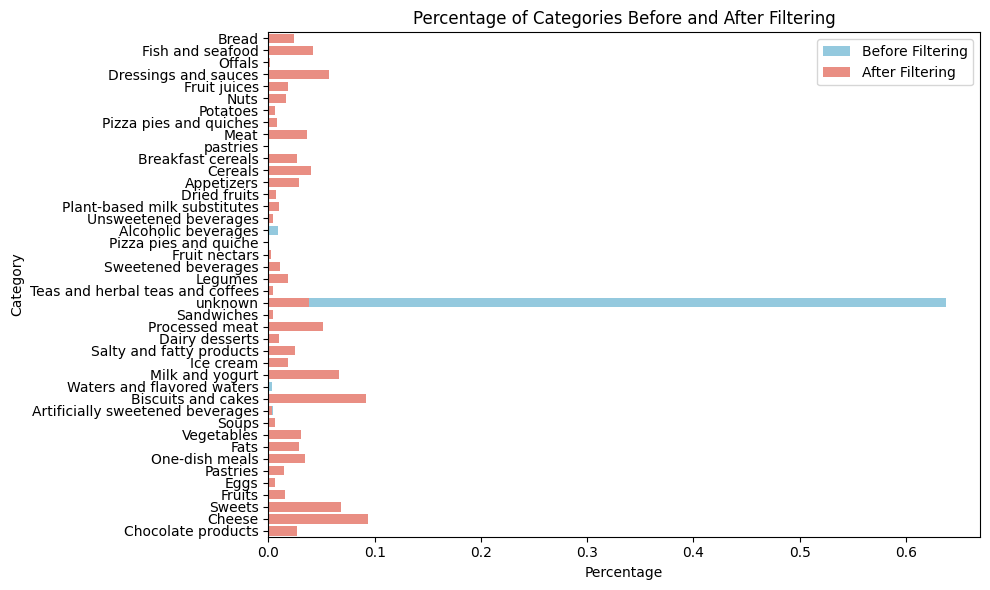

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts of categories before and after filtering
before_filtering = df['pnns_groups_2'].value_counts(normalize=True)
after_filtering = filtered_df['pnns_groups_2'].value_counts(normalize=True)

# Concatenate the before and after filtering counts, ensuring missing categories are included in both
all_categories = list(set(before_filtering.index) | set(after_filtering.index))
before_filtering = before_filtering.reindex(all_categories, fill_value=0)
after_filtering = after_filtering.reindex(all_categories, fill_value=0)

# Create a DataFrame to hold the comparison
comparison_df = pd.DataFrame({'Category': all_categories,
                              'Before_Filtering': before_filtering.values,
                              'After_Filtering': after_filtering.values})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Before_Filtering', y='Category', data=comparison_df, color='skyblue', label='Before Filtering')
sns.barplot(x='After_Filtering', y='Category', data=comparison_df, color='salmon', label='After Filtering')
plt.xlabel('Percentage')
plt.ylabel('Category')
plt.title('Percentage of Categories Before and After Filtering')
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/228307860.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after_filtering = filtered_df[df['pnns_groups_2'] != 'unknown']['pnns_groups_2'].value_counts(normalize=True)


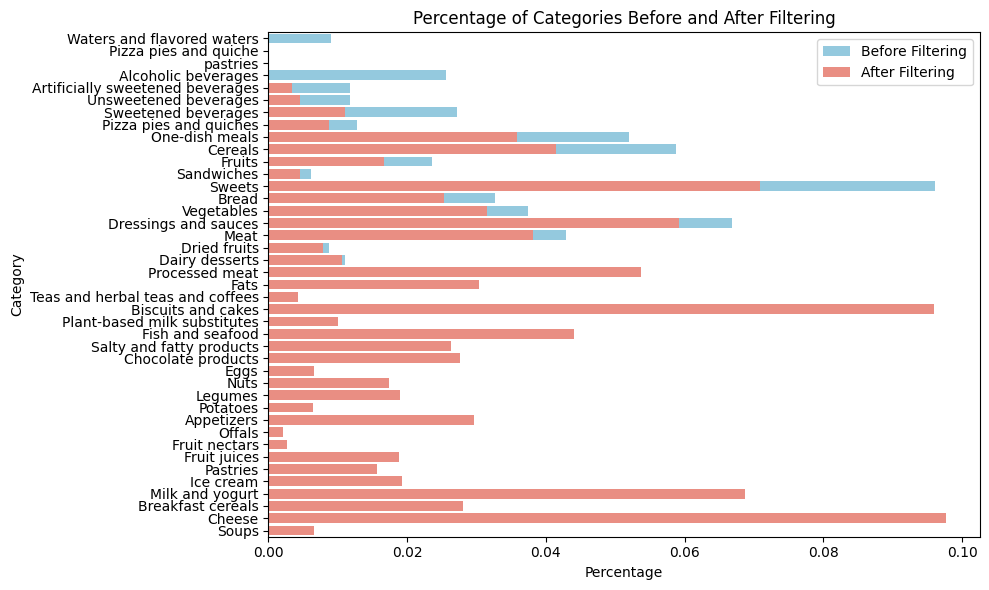

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts of categories before and after filtering
before_filtering = df[df['pnns_groups_2'] != 'unknown']['pnns_groups_2'].value_counts(normalize=True)
after_filtering = filtered_df[df['pnns_groups_2'] != 'unknown']['pnns_groups_2'].value_counts(normalize=True)

# Concatenate the before and after filtering counts, ensuring missing categories are included in both
all_categories = list(set(before_filtering.index) | set(after_filtering.index))
before_filtering = before_filtering.reindex(all_categories, fill_value=0)
after_filtering = after_filtering.reindex(all_categories, fill_value=0)

# Calculate the difference between before and after filtering percentages
difference = (before_filtering - after_filtering)/before_filtering

# Create a DataFrame to hold the comparison
comparison_df = pd.DataFrame({'Category': all_categories,
                              'Before_Filtering': before_filtering.values,
                              'After_Filtering': after_filtering.values,
                              'Difference': difference})

# Sort the DataFrame based on the difference
comparison_df_sorted = comparison_df.sort_values(by='Difference', ascending=False)

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Before_Filtering', y='Category', data=comparison_df_sorted, color='skyblue', label='Before Filtering')
sns.barplot(x='After_Filtering', y='Category', data=comparison_df_sorted, color='salmon', label='After Filtering')
plt.xlabel('Percentage')
plt.ylabel('Category')
plt.title('Percentage of Categories Before and After Filtering')
plt.legend()
plt.tight_layout()
plt.show()


## IX - Score Distribution Analysis

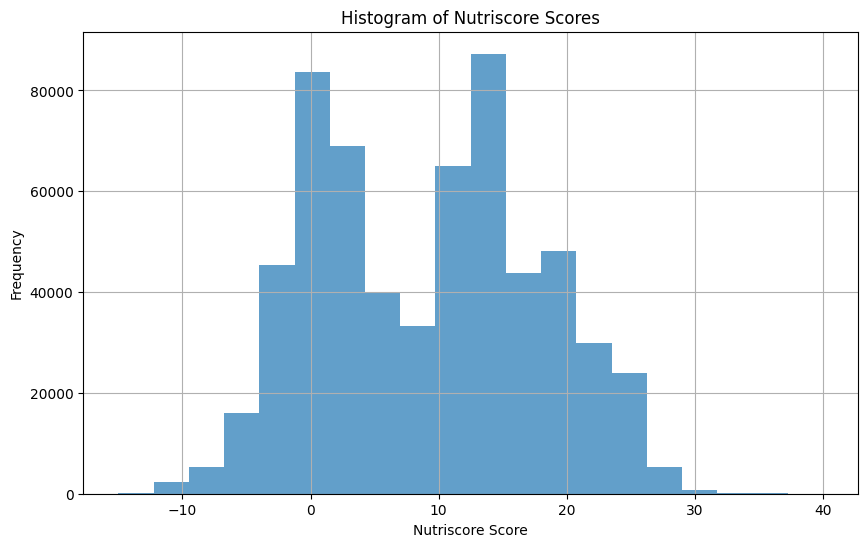

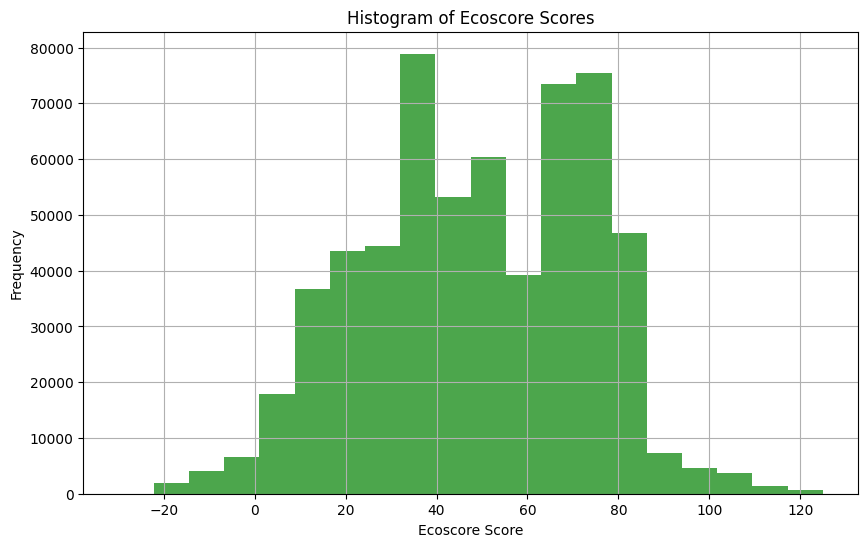

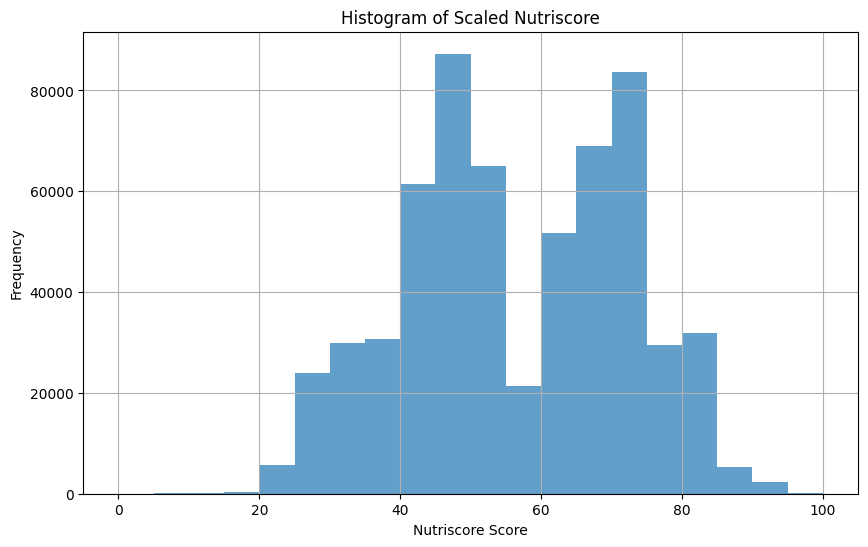

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame loaded previously

# Histogram for Nutriscore
plt.figure(figsize=(10, 6))
filtered_df['nutriscore_score'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Histogram of Nutriscore Scores')
plt.xlabel('Nutriscore Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for Ecoscore
plt.figure(figsize=(10, 6))
filtered_df['ecoscore_score'].plot(kind='hist', bins=20, alpha=0.7, color='green')
plt.title('Histogram of Ecoscore Scores')
plt.xlabel('Ecoscore Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Histogram for Ecoscore
plt.figure(figsize=(10, 6))
filtered_df['Scaled_NutriScore'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Histogram of Scaled Nutriscore')
plt.xlabel('Nutriscore Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## X - Combined Score

In [ ]:
# Define the weights for the scores
w1 = 0.5  # Replace with the actual weight for NutriScore
w2 = 0.5  # Replace with the actual weight for EcoScore

# Calculate the Scaled NutriScore
filtered_df['Scaled_NutriScore'] = (40 - filtered_df['nutriscore_score']) / (40 + 15) * 100

# Calculate the Combined Score
filtered_df['Combined_Score'] = (w1 * filtered_df['Scaled_NutriScore']) + (w2 * filtered_df['ecoscore_score'])

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/3338072099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Scaled_NutriScore'] = (40 - filtered_df['nutriscore_score']) / (40 + 15) * 100
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/3338072099.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Combined_Score'] = (w1 * filtered_df['Scaled_NutriScore']) + (w2 * filtered_df['ecoscore_score'])


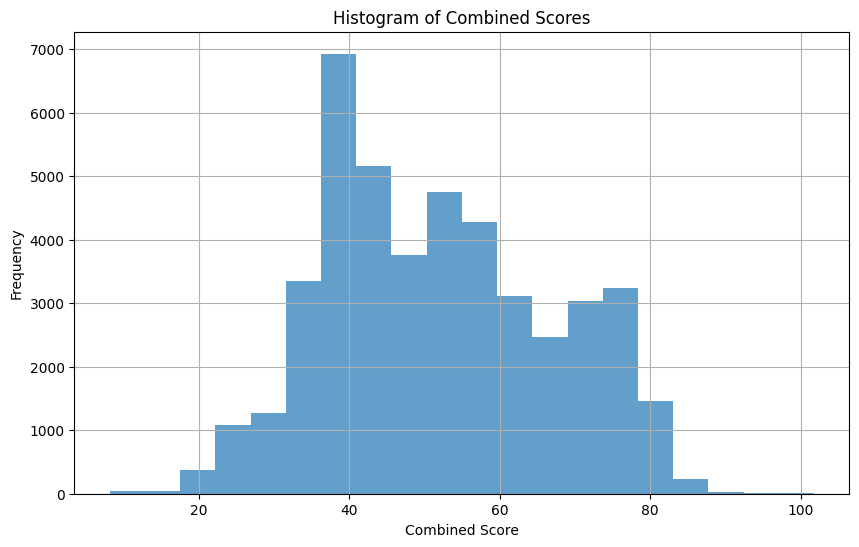

In [ ]:
# Plot a histogram of the Combined Score
plt.figure(figsize=(10, 6))
filtered_df['Combined_Score'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Histogram of Combined Scores')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## XI - Category Analysis

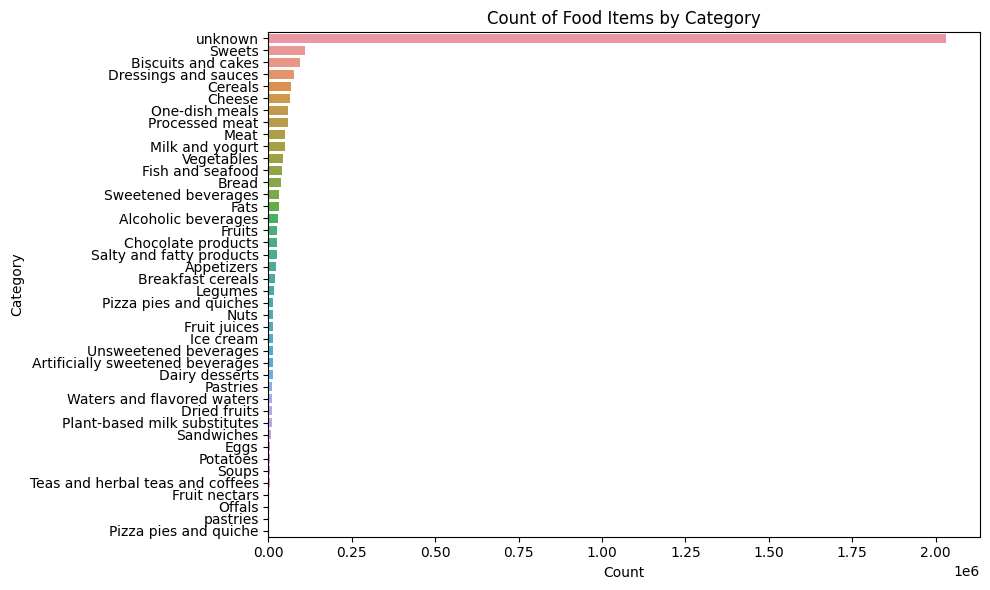

In [58]:
plt.figure(figsize=(10, 6))
sns.countplot(y='pnns_groups_2', data=df, order=df['pnns_groups_2'].value_counts().index)
plt.title('Count of Food Items by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

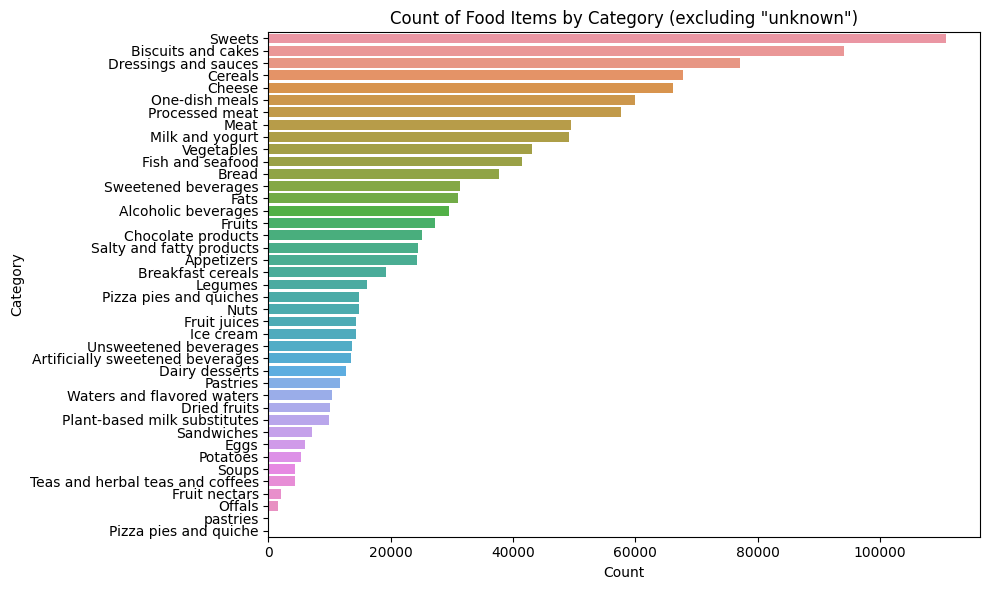

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='pnns_groups_2', data=df[df['pnns_groups_2'] != 'unknown'], 
              order=df[df['pnns_groups_2'] != 'unknown']['pnns_groups_2'].value_counts().index)
plt.title('Count of Food Items by Category (excluding "unknown")')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

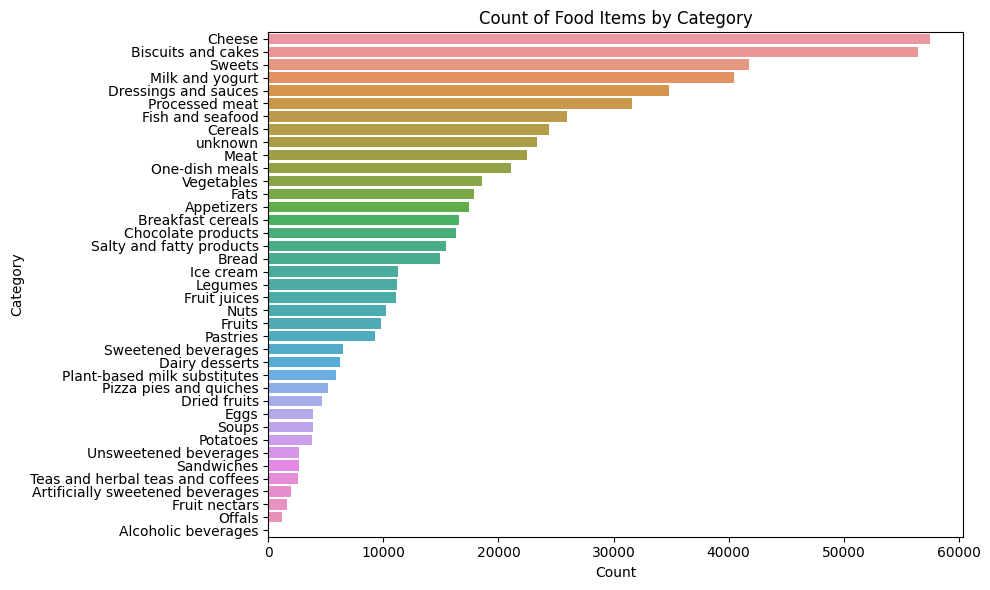

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='pnns_groups_2', data=filtered_df, order=filtered_df['pnns_groups_2'].value_counts().index)
plt.title('Count of Food Items by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

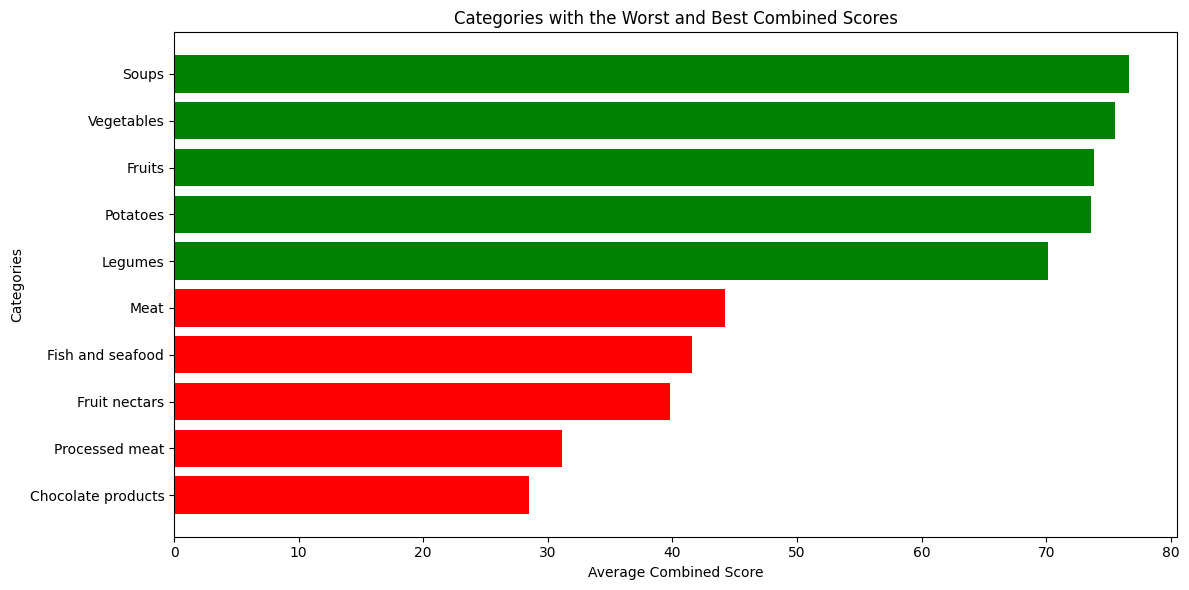

In [ ]:
# Group by 'categories' and calculate the mean of 'Combined_Score' for each category
category_scores = filtered_df.groupby('pnns_groups_2')['Combined_Score'].mean().sort_values()

# Let's say you want to see the top and bottom 5 categories
top_categories = category_scores.head(5)
bottom_categories = category_scores.tail(5)

# Combine top and bottom categories into one Series
combined_categories = pd.concat([top_categories, bottom_categories])

# Truncate category labels to the first 15 characters plus an ellipsis
truncated_labels = [label[:15] + '...' if len(label) > 30 else label for label in combined_categories.index]

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(range(len(combined_categories)), combined_categories, color=['red' if score in top_categories.values else 'green' for score in combined_categories.values])
plt.yticks(range(len(combined_categories)), truncated_labels)
plt.title('Categories with the Worst and Best Combined Scores')
plt.xlabel('Average Combined Score')
plt.ylabel('Categories')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


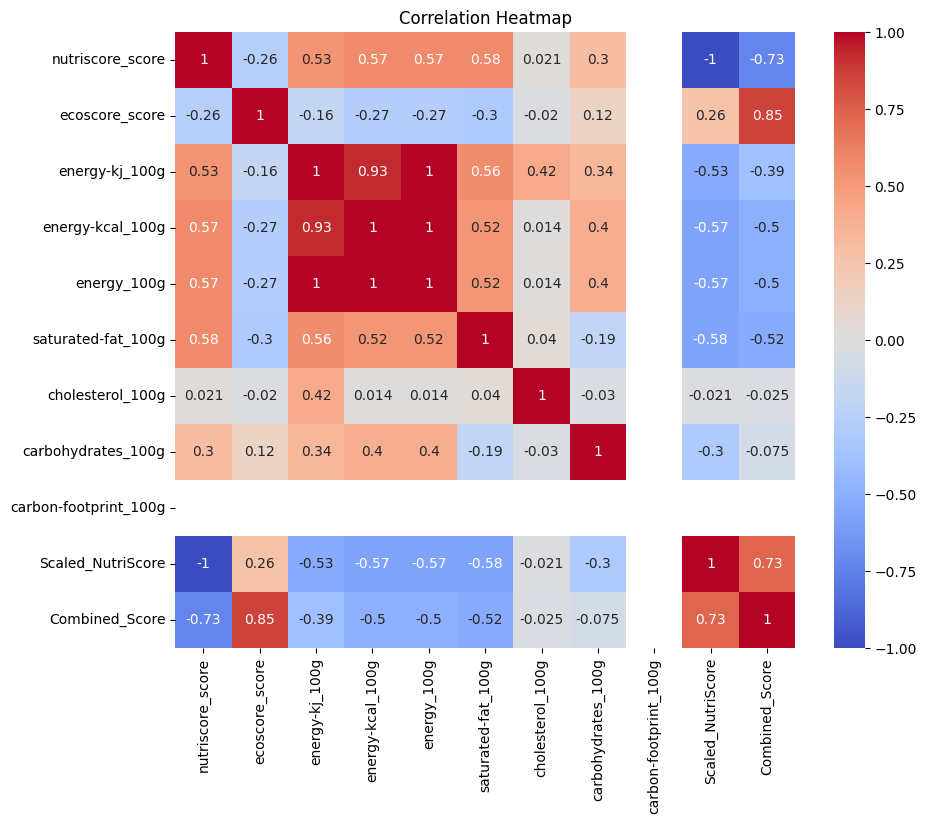

In [ ]:
numerical_df = filtered_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/14013611.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/14013611.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(color_map)


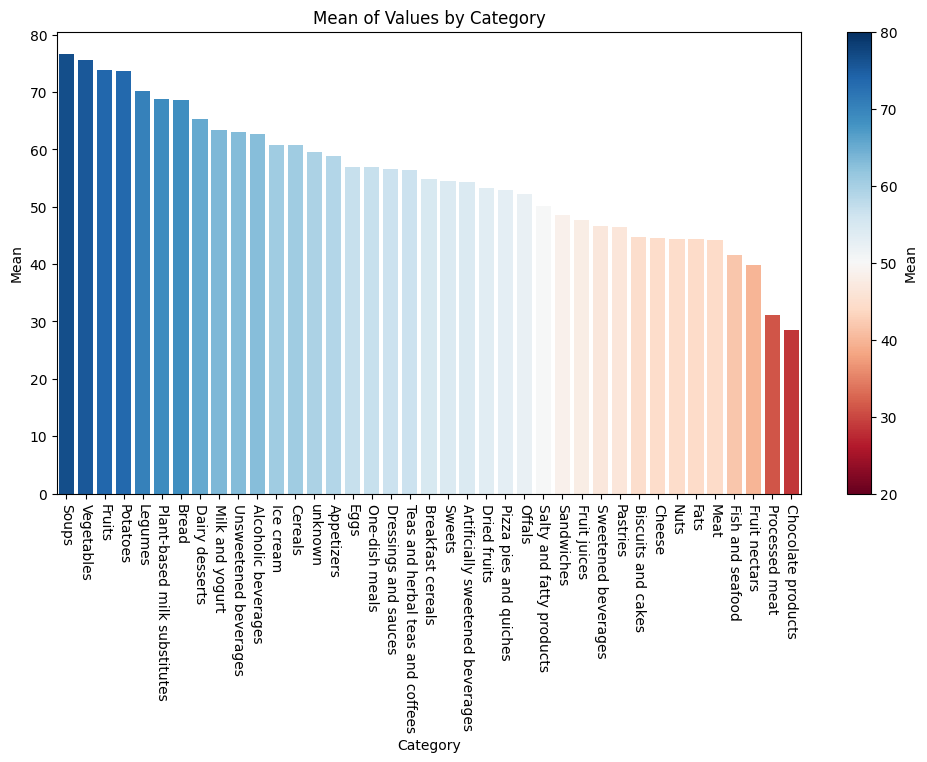

In [111]:
# Calculate range, standard deviation, and skewness for each category
statistics_df = filtered_df.groupby('pnns_groups_2')['Combined_Score'].agg(['min', 'max', 'std', 'skew', 'mean']).reset_index()
statistics_df['range'] = statistics_df['max'] - statistics_df['min']

# Create a color map using a colormap from matplotlib
cmap = cm.get_cmap('RdBu')
norm = colors.Normalize(vmin=20, vmax=80)
color_map = cm.ScalarMappable(norm=norm, cmap=cmap)

# Sort the statistics DataFrame by the desired column
statistics_df_mean_sorted = statistics_df.sort_values(by='mean', ascending=False).reset_index(drop=True)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the range of values by category with color mapped to Combined_Score
sns.barplot(x='pnns_groups_2', y='mean', data=statistics_df_mean_sorted, ax=ax)
for i, row in statistics_df_mean_sorted.iterrows():
    color = color_map.to_rgba(row['mean'])
    ax.patches[i].set_facecolor(color)
ax.set_xlabel('Category')
ax.set_ylabel('Mean')
ax.set_title('Mean of Values by Category')
plt.xticks(rotation=270)
cbar = fig.colorbar(color_map)
cbar.set_label('Mean')
plt.show()

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/1181050433.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/1181050433.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(color_map)


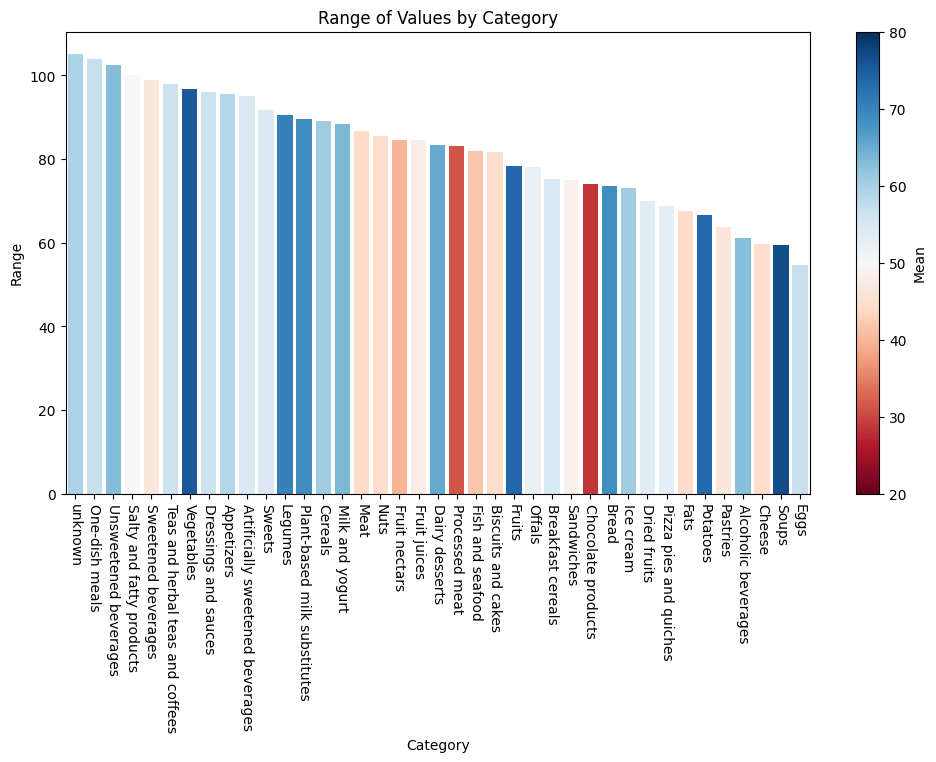

In [108]:
# Sort the statistics DataFrame by the desired column
statistics_df_range_sorted = statistics_df.sort_values(by='range', ascending=False).reset_index(drop=True)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the range of values by category with color mapped to Combined_Score
sns.barplot(x='pnns_groups_2', y='range', data=statistics_df_range_sorted, ax=ax)
for i, row in statistics_df_range_sorted.iterrows():
    color = color_map.to_rgba(row['mean'])
    ax.patches[i].set_facecolor(color)
ax.set_xlabel('Category')
ax.set_ylabel('Range')
ax.set_title('Range of Values by Category')
plt.xticks(rotation=270)
cbar = fig.colorbar(color_map)
cbar.set_label('Mean')
plt.show()


/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/586319517.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(color_map)


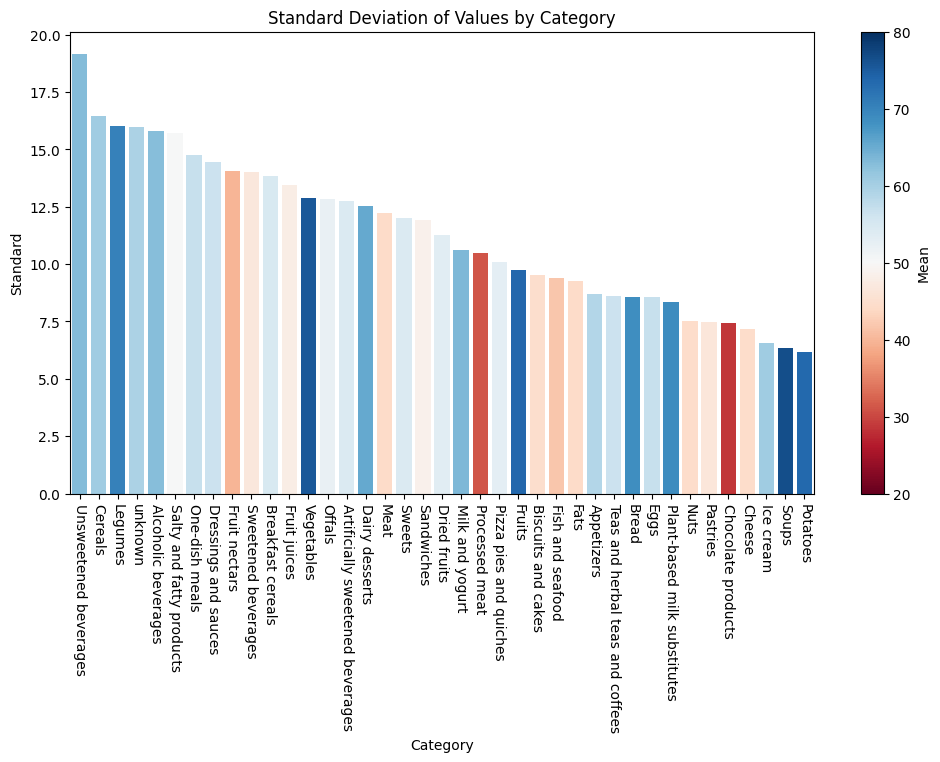

In [109]:
# Sort the statistics DataFrame by the desired column
statistics_df_std_sorted = statistics_df.sort_values(by='std', ascending=False).reset_index(drop=True)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the standard deviation of values by category
sns.barplot(x='pnns_groups_2', y='std', data=statistics_df_std_sorted, ax=ax)
for i, row in statistics_df_std_sorted.iterrows():
    color = color_map.to_rgba(row['mean'])
    ax.patches[i].set_facecolor(color)
ax.set_xlabel('Category')
ax.set_ylabel('Standard')
ax.set_title('Standard Deviation of Values by Category')
plt.xticks(rotation=270)
cbar = fig.colorbar(color_map)
cbar.set_label('Mean')
plt.show()

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/2865079797.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(color_map)


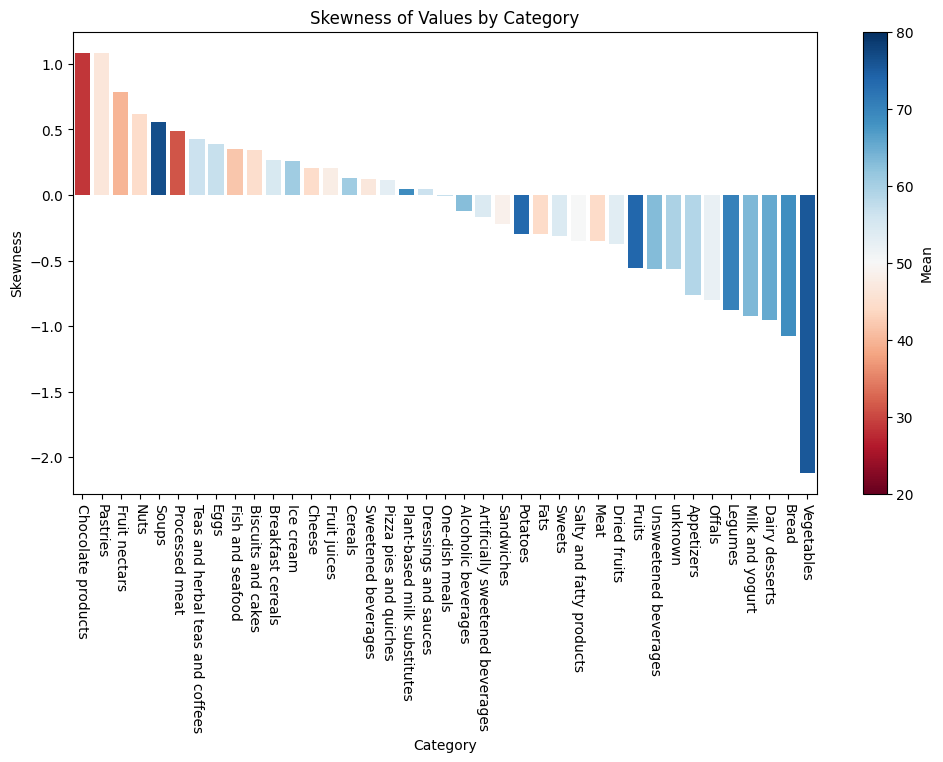

In [110]:
# Sort the statistics DataFrame by the desired column
statistics_df_skew_sorted = statistics_df.sort_values(by='skew', ascending=False).reset_index(drop=True)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the skewness of values by category
sns.barplot(x='pnns_groups_2', y='skew', data=statistics_df_skew_sorted, ax=ax)
for i, row in statistics_df_skew_sorted.iterrows():
    color = color_map.to_rgba(row['mean'])
    ax.patches[i].set_facecolor(color)
ax.set_xlabel('Category')
ax.set_ylabel('Skewness')
ax.set_title('Skewness of Values by Category')
plt.xticks(rotation=270)
cbar = fig.colorbar(color_map)
cbar.set_label('Mean')
plt.show()

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/518774304.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(soups['Combined_Score'], shade=True)


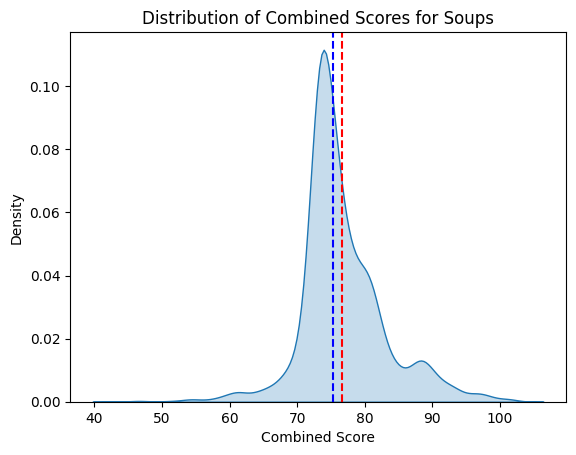

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/518774304.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(meats['Combined_Score'], shade=True)


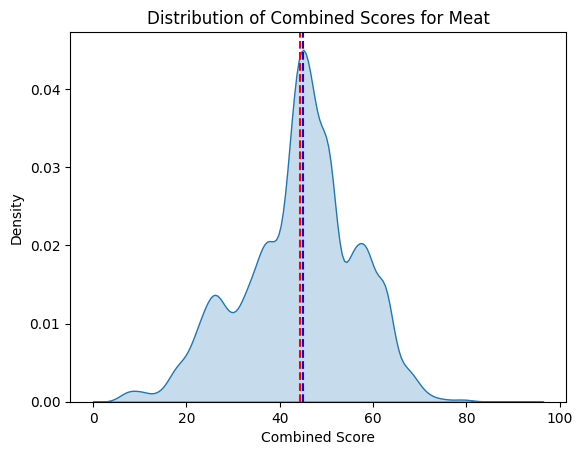

In [165]:
soups = filtered_df[filtered_df['pnns_groups_2']=='Soups']
mean_score = soups['Combined_Score'].mean()
median_score = soups['Combined_Score'].median()

sns.kdeplot(soups['Combined_Score'], shade=True)
plt.axvline(mean_score, linestyle='--', color='red', label='Mean')
plt.axvline(median_score, linestyle='--', color='blue', label='Median')
plt.xlabel('Combined Score')
plt.ylabel('Density')
plt.title('Distribution of Combined Scores for Soups')
plt.show()

meats = filtered_df[filtered_df['pnns_groups_2']=='Meat']
mean_score = meats['Combined_Score'].mean()
median_score = meats['Combined_Score'].median()

sns.kdeplot(meats['Combined_Score'], shade=True)
plt.axvline(mean_score, linestyle='--', color='red', label='Mean')
plt.axvline(median_score, linestyle='--', color='blue', label='Median')
plt.xlabel('Combined Score')
plt.ylabel('Density')
plt.title('Distribution of Combined Scores for Meat')
plt.show()

## XII - Influence of Nutriscore over Ecoscore

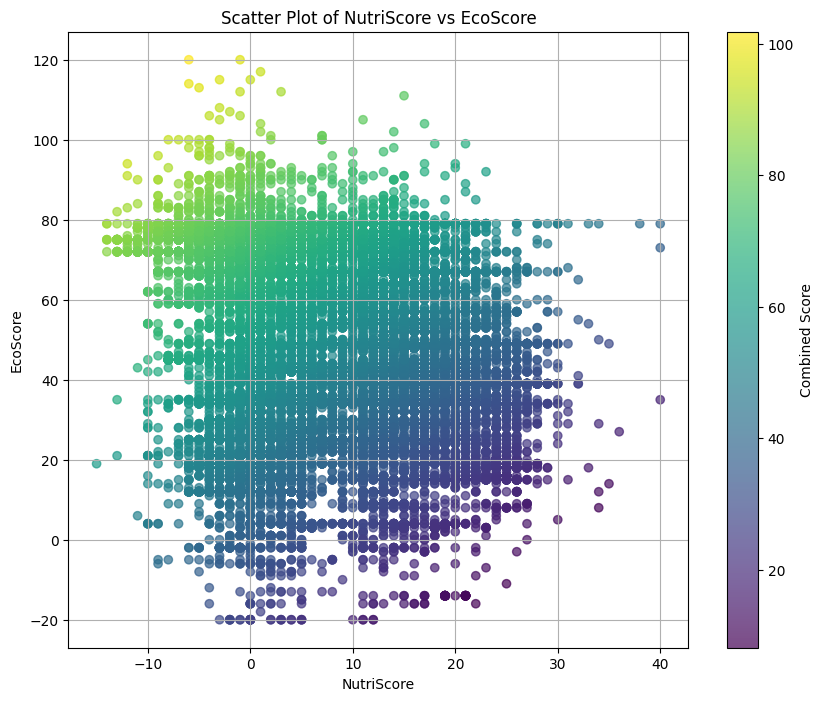

In [ ]:
# Scatter plot with nutriscore_score on x-axis, ecoscore_score on y-axis
# Use the combined_score to determine the color intensity of the points
plt.figure(figsize=(10, 8))
plt.scatter(filtered_df['nutriscore_score'], filtered_df['ecoscore_score'], c=filtered_df['Combined_Score'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Combined Score')
plt.title('Scatter Plot of NutriScore vs EcoScore')
plt.xlabel('NutriScore')
plt.ylabel('EcoScore')
plt.grid(True)
plt.show()


In [ ]:
# Objective 4: Influence of Ecoscore vs. Nutriscore
nutriscore_std = filtered_df['Scaled_NutriScore'].std()
ecoscore_std = filtered_df['ecoscore_score'].std()
print("Standard deviation - Nutriscore:", nutriscore_std, "Ecoscore:", ecoscore_std)

nutriscore_range = filtered_df['Scaled_NutriScore'].max() - filtered_df['Scaled_NutriScore'].min()
ecoscore_range = filtered_df['ecoscore_score'].max() - filtered_df['ecoscore_score'].min()
print("Range - Nutriscore:", nutriscore_range, "Ecoscore:", ecoscore_range)

Standard deviation - Nutriscore: 15.838873094557284 Ecoscore: 24.49084421315701
Range - Nutriscore: 100.0 Ecoscore: 155.0


## XIII - Country Analysis

In [129]:
country_df = filtered_df[['countries', 'Combined_Score', 'pnns_groups_2']].dropna()
country_df['countries'] = country_df['countries'].apply(lambda x: x.split(','))
country_df = country_df.explode('countries')
country_df['countries'] = country_df['countries'].str.strip()

# Lowercasing country names and removing 'en:' prefix
country_df['countries'] = country_df['countries'].str.lower().replace(r'^en:', '', regex=True)

country_df['cleaned_countries'] = country_df['countries'].map(country_mapping)

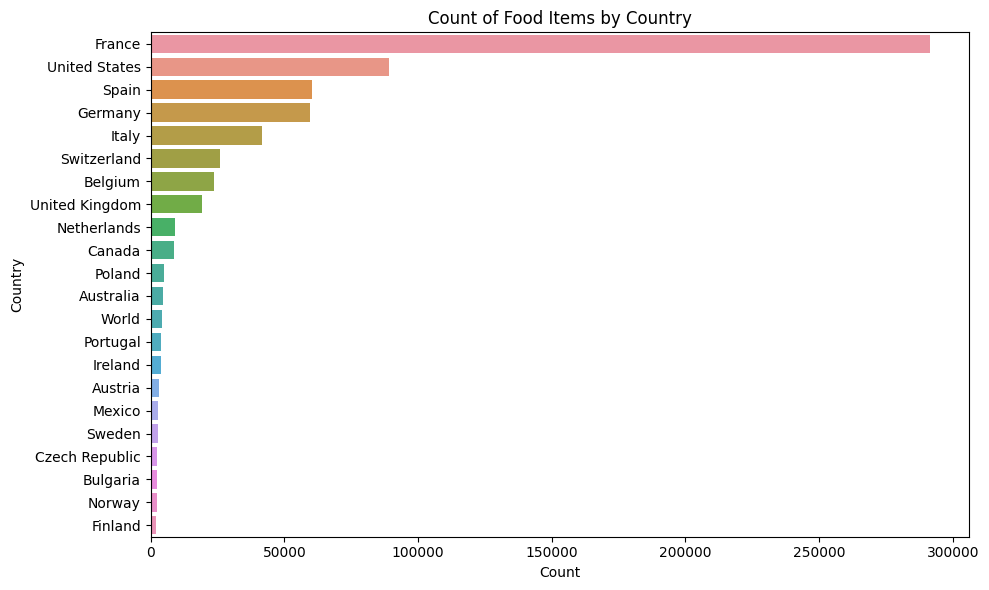

In [128]:
country_df_filtered = country_df.groupby('cleaned_countries').filter(lambda x: len(x) >= 2000)

plt.figure(figsize=(10, 6))
sns.countplot(y='cleaned_countries', data=country_df_filtered, order=country_df_filtered['cleaned_countries'].value_counts().index)
plt.title('Count of Food Items by Country')
plt.xlabel('Count')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [ ]:
average_scores = country_df.groupby('cleaned_countries')['Combined_Score'].mean().sort_values().reset_index()

# Selecting top 10 countries with the highest and lowest average scores
top_10_highest = average_scores.nlargest(10, 'Combined_Score')
top_10_lowest = average_scores.nsmallest(10, 'Combined_Score')

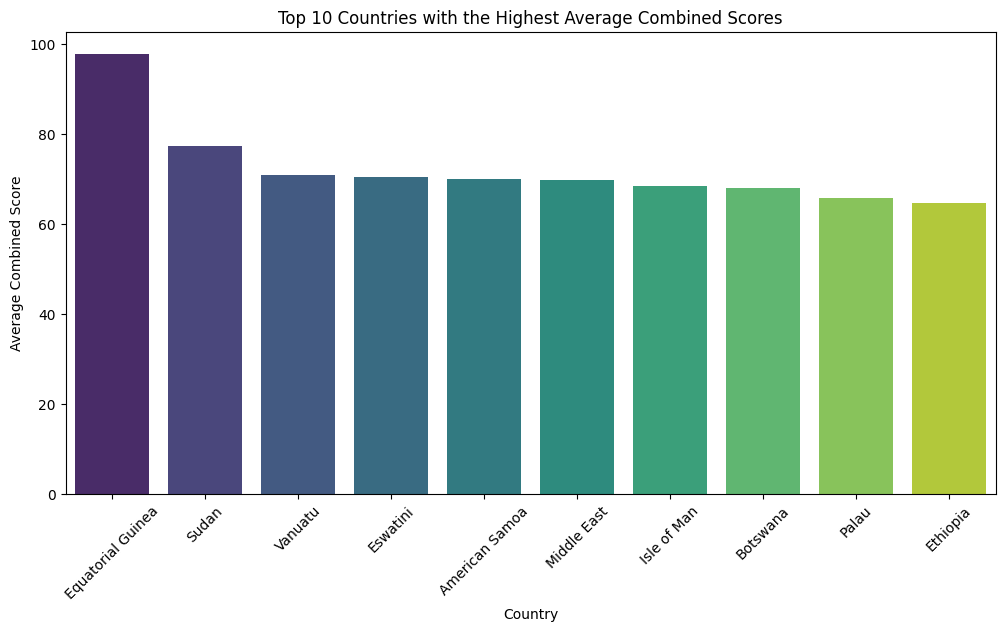

In [ ]:
# Visualization for Top 10 Highest Scoring Countries
plt.figure(figsize=(12, 6))
sns.barplot(x='cleaned_countries', y='Combined_Score', data=top_10_highest, palette='viridis')
plt.title('Top 10 Countries with the Highest Average Combined Scores')
plt.xlabel('Country')
plt.ylabel('Average Combined Score')
plt.xticks(rotation=45)  # Rotate labels to fit longer names
plt.show()

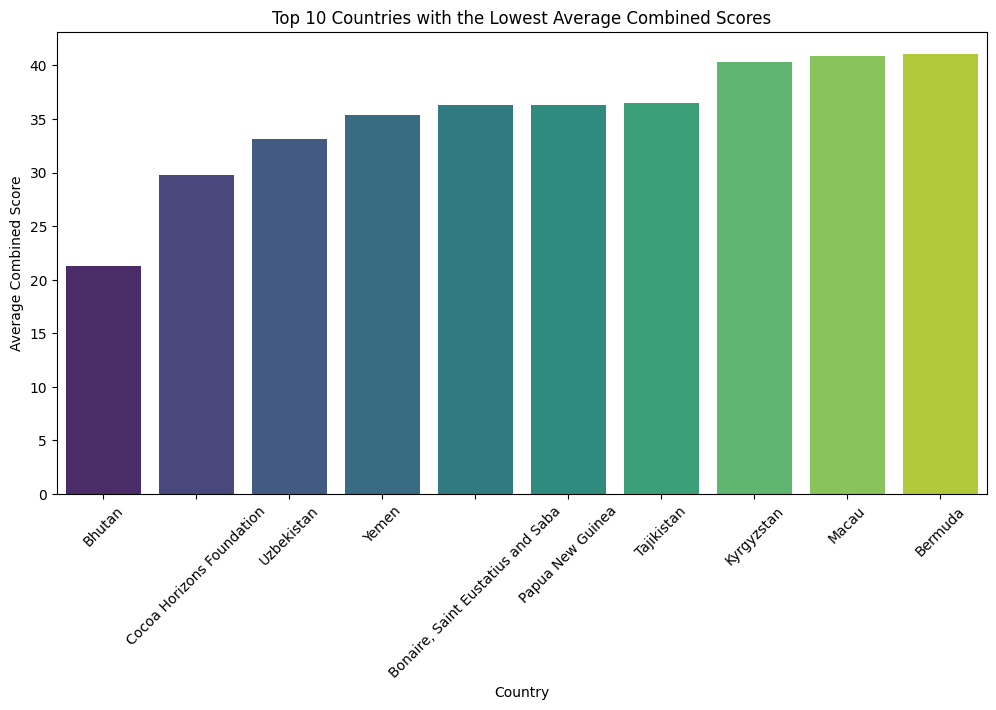

In [ ]:
# Visualization for Top 10 Lowest Scoring Countries
plt.figure(figsize=(12, 6))
sns.barplot(x='cleaned_countries', y='Combined_Score', data=top_10_lowest, palette='viridis')
plt.title('Top 10 Countries with the Lowest Average Combined Scores')
plt.xlabel('Country')
plt.ylabel('Average Combined Score')
plt.xticks(rotation=45)
plt.show()

In [136]:
country_stats_df = country_df.groupby(['cleaned_countries', 'pnns_groups_2'])['Combined_Score'].agg(['mean', 'count']).reset_index()
country_stats_df.head()

,cleaned_countries,pnns_groups_2,mean,count
0,Afghanistan,Appetizers,66.727273,1
1,Afghanistan,Artificially sweetened beverages,42.818182,1
2,Afghanistan,Biscuits and cakes,52.113636,2
3,Afghanistan,Cereals,75.500000,1
4,Afghanistan,Cheese,46.636364,2


In [145]:
top_10 = top_10_highest['cleaned_countries'].head(10).to_list()

for country in top_10:
    cats = country_stats_df[country_stats_df['cleaned_countries']==country]
    max_cat = cats.loc[cats['count'].idxmax()]
    total_count = cats['count'].sum()
    num_cats = len(cats)
    print(f"{country}:")
    print(f"\tMost common category: {max_cat['pnns_groups_2']} ({max_cat['count']} items)")
    print(f"\tTotal items: {total_count}")
    print(f"\tNumber of categories: {num_cats}")
    print()

Equatorial Guinea:
	Most common category: Legumes (1 items)
	Total items: 1
	Number of categories: 1

Sudan:
	Most common category: Sweets (1 items)
	Total items: 1
	Number of categories: 1

Vanuatu:
	Most common category: Appetizers (1 items)
	Total items: 3
	Number of categories: 3

Eswatini:
	Most common category: Milk and yogurt (1 items)
	Total items: 2
	Number of categories: 2

American Samoa:
	Most common category: Milk and yogurt (1 items)
	Total items: 2
	Number of categories: 2

Middle East:
	Most common category: Milk and yogurt (1 items)
	Total items: 1
	Number of categories: 1

Isle of Man:
	Most common category: Bread (2 items)
	Total items: 8
	Number of categories: 7

Botswana:
	Most common category: Legumes (1 items)
	Total items: 2
	Number of categories: 2

Palau:
	Most common category: Dressings and sauces (1 items)
	Total items: 1
	Number of categories: 1

Ethiopia:
	Most common category: Breakfast cereals (1 items)
	Total items: 2
	Number of categories: 2



In [146]:
low_10 = top_10_lowest['cleaned_countries'].head(10).to_list()

for country in low_10:
    cats = country_stats_df[country_stats_df['cleaned_countries']==country]
    max_cat = cats.loc[cats['count'].idxmax()]
    total_count = cats['count'].sum()
    num_cats = len(cats)
    print(f"{country}:")
    print(f"\tMost common category: {max_cat['pnns_groups_2']} ({max_cat['count']} items)")
    print(f"\tTotal items: {total_count}")
    print(f"\tNumber of categories: {num_cats}")
    print()

Bhutan:
	Most common category: Chocolate products (1 items)
	Total items: 1
	Number of categories: 1

Cocoa Horizons Foundation:
	Most common category: Biscuits and cakes (1 items)
	Total items: 1
	Number of categories: 1

Uzbekistan:
	Most common category: Appetizers (1 items)
	Total items: 4
	Number of categories: 4

Yemen:
	Most common category: Biscuits and cakes (1 items)
	Total items: 2
	Number of categories: 2

Bonaire, Saint Eustatius and Saba:
	Most common category: Cereals (1 items)
	Total items: 1
	Number of categories: 1

Papua New Guinea:
	Most common category: Dried fruits (1 items)
	Total items: 1
	Number of categories: 1

Tajikistan:
	Most common category: Sweets (1 items)
	Total items: 1
	Number of categories: 1

Kyrgyzstan:
	Most common category: Chocolate products (2 items)
	Total items: 4
	Number of categories: 3

Macau:
	Most common category: Salty and fatty products (3 items)
	Total items: 12
	Number of categories: 8

Bermuda:
	Most common category: Appetizers (1 

In [152]:
country_counts = country_df.groupby('cleaned_countries')['Combined_Score'].count().reset_index()

# Filter to only include countries with more than 1000 food items
country_counts = country_counts[country_counts['Combined_Score'] > 200]

# Calculate average scores for the remaining countries
average_scores = country_df[country_df['cleaned_countries'].isin(country_counts['cleaned_countries'])].groupby('cleaned_countries')['Combined_Score'].mean().reset_index()

# Selecting top 10 countries with the highest and lowest average scores
top_10_highest = average_scores.nlargest(10, 'Combined_Score')
top_10_lowest = average_scores.nsmallest(10, 'Combined_Score')

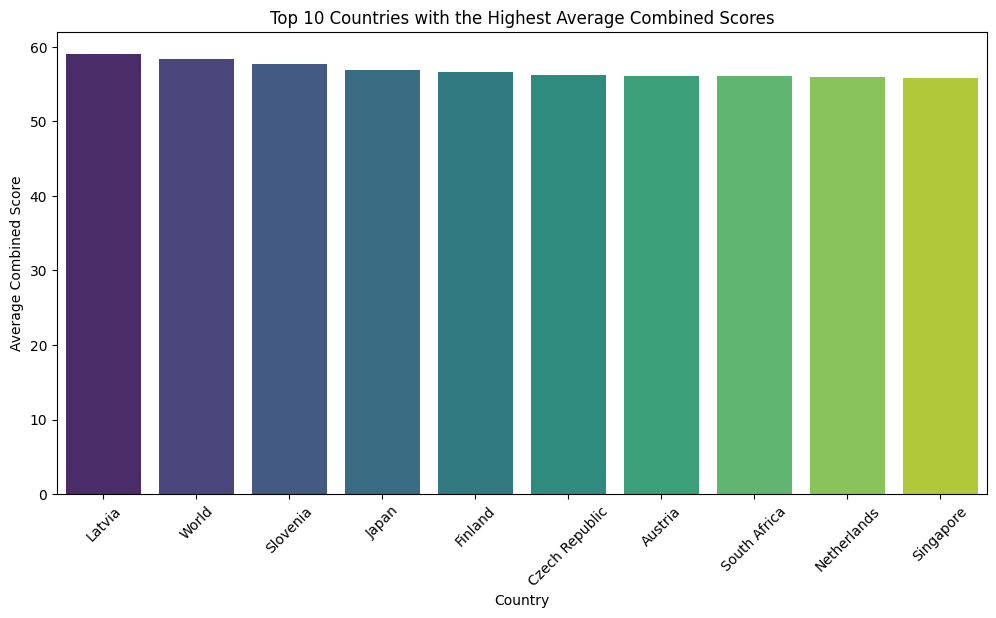

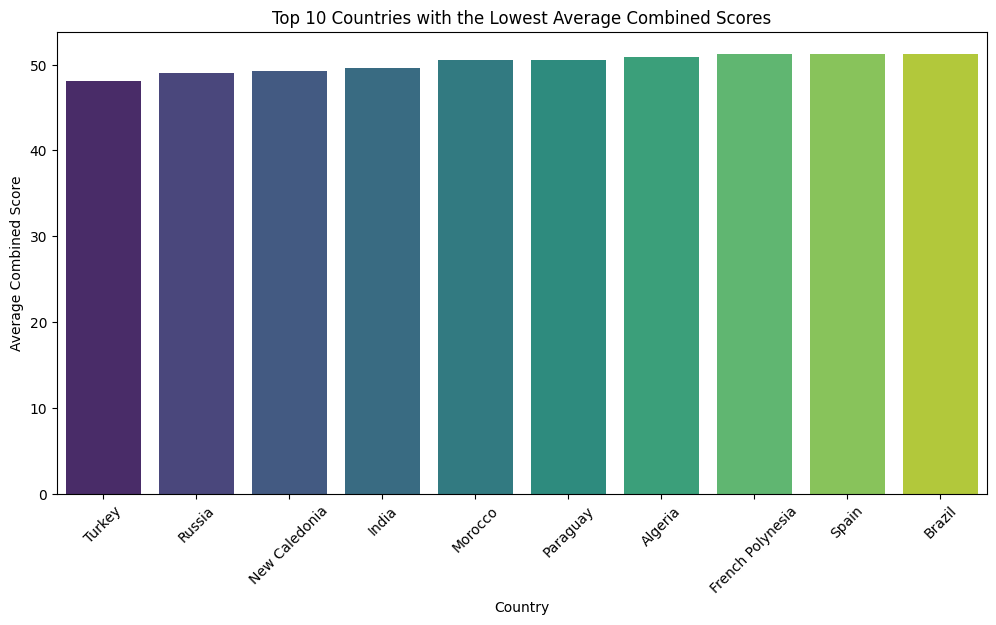

In [154]:
# Visualization for Top 10 Highest Scoring Countries
plt.figure(figsize=(12, 6))
sns.barplot(x='cleaned_countries', y='Combined_Score', data=top_10_highest, palette='viridis')
plt.title('Top 10 Countries with the Highest Average Combined Scores')
plt.xlabel('Country')
plt.ylabel('Average Combined Score')
plt.xticks(rotation=45)
plt.show()

# Visualization for Top 10 Lowest Scoring Countries
plt.figure(figsize=(12, 6))
sns.barplot(x='cleaned_countries', y='Combined_Score', data=top_10_lowest, palette='viridis')
plt.title('Top 10 Countries with the Lowest Average Combined Scores')
plt.xlabel('Country')
plt.ylabel('Average Combined Score')
plt.xticks(rotation=45)
plt.show()

In [155]:
low_10 = top_10_lowest['cleaned_countries'].head(10).to_list()

for country in low_10:
    cats = country_stats_df[country_stats_df['cleaned_countries']==country]
    max_cat = cats.loc[cats['count'].idxmax()]
    total_count = cats['count'].sum()
    num_cats = len(cats)
    print(f"{country}:")
    print(f"\tMost common category: {max_cat['pnns_groups_2']} ({max_cat['count']} items)")
    print(f"\tTotal items: {total_count}")
    print(f"\tNumber of categories: {num_cats}")
    print()

Turkey:
	Most common category: Biscuits and cakes (38 items)
	Total items: 211
	Number of categories: 29

Russia:
	Most common category: Chocolate products (53 items)
	Total items: 275
	Number of categories: 23

New Caledonia:
	Most common category: Chocolate products (50 items)
	Total items: 376
	Number of categories: 35

India:
	Most common category: Biscuits and cakes (143 items)
	Total items: 680
	Number of categories: 30

Morocco:
	Most common category: Biscuits and cakes (263 items)
	Total items: 1498
	Number of categories: 35

Paraguay:
	Most common category: Biscuits and cakes (94 items)
	Total items: 264
	Number of categories: 23

Algeria:
	Most common category: Biscuits and cakes (115 items)
	Total items: 665
	Number of categories: 33

French Polynesia:
	Most common category: Biscuits and cakes (71 items)
	Total items: 424
	Number of categories: 35

Spain:
	Most common category: Cheese (5861 items)
	Total items: 60214
	Number of categories: 39

Brazil:
	Most common category: 

## XIV - Analysing the results

In [167]:
chocolate = filtered_df[filtered_df['pnns_groups_2']=='Chocolate products']
chocolate.columns

Index(['product_name', 'quantity', 'packaging', 'packaging_tags',
       'packaging_en', 'categories', 'origins', 'origins_tags', 'origins_en',
       'countries', 'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1',
       'pnns_groups_2', 'food_groups', 'brand_owner', 'ecoscore_score',
       'ecoscore_grade', 'popularity_tags', 'main_category_en',
       'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'saturated-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'carbon-footprint_100g', 'Scaled_NutriScore',
       'Combined_Score'],
      dtype='object')

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_36811/1115547763.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(soups['carbon-footprint_100g'], label='Soups', ax=axs[1, 2])


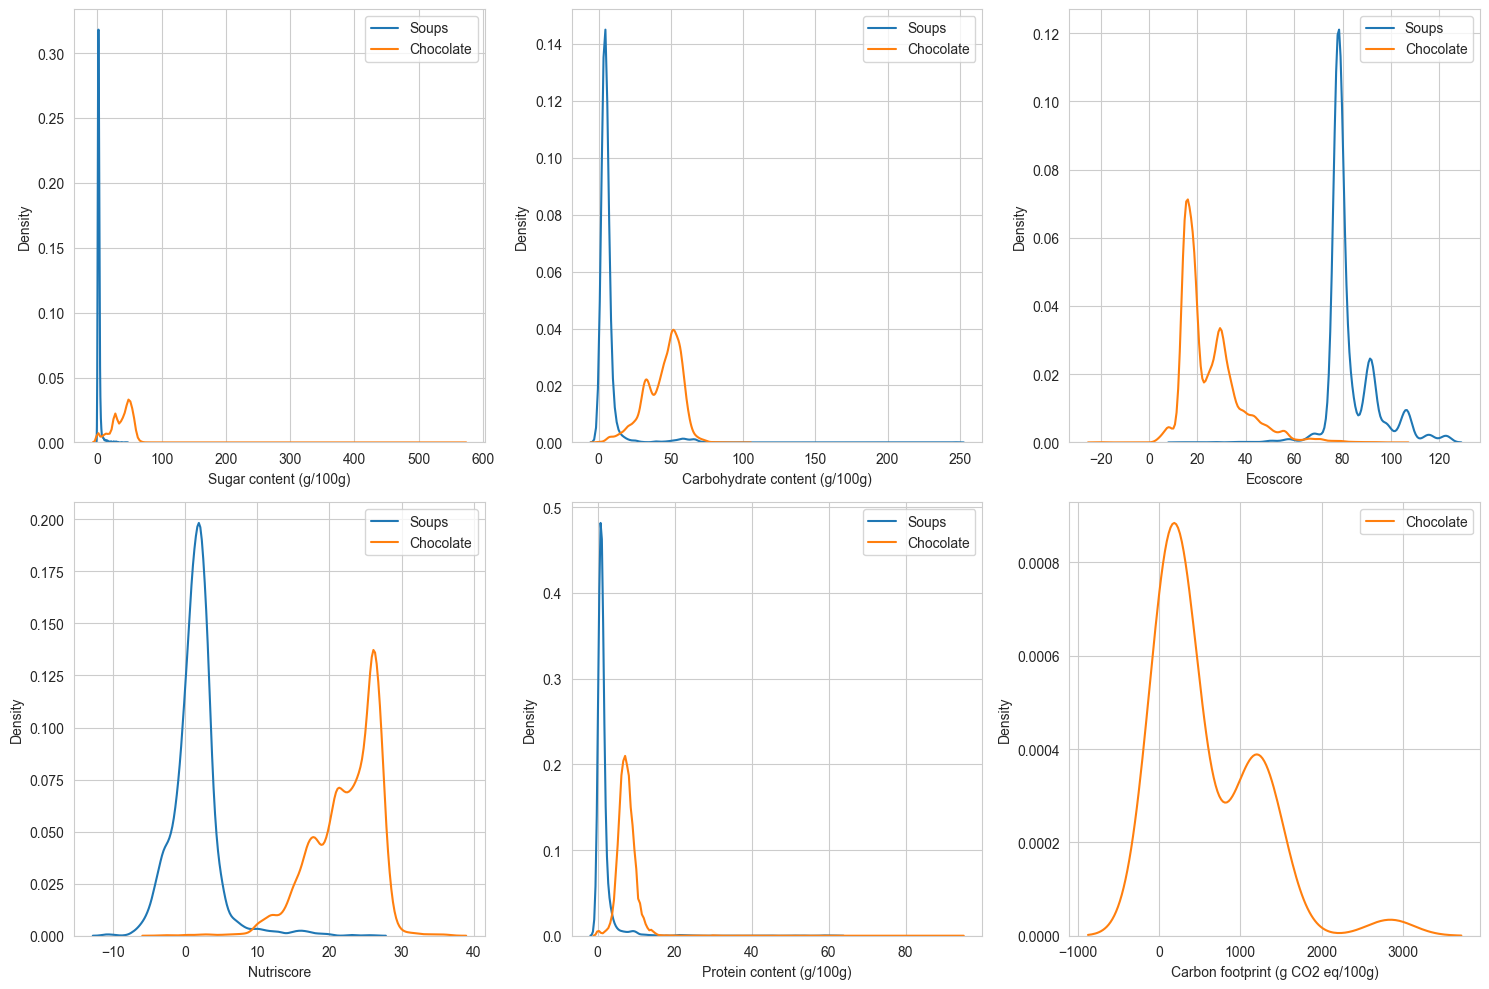

In [168]:
# Set plotting style
sns.set_style('whitegrid')

# Create subplots for each variable
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot KDE for sugar content
sns.kdeplot(soups['sugars_100g'], label='Soups', ax=axs[0, 0])
sns.kdeplot(chocolate['sugars_100g'], label='Chocolate', ax=axs[0, 0])
axs[0, 0].set_xlabel('Sugar content (g/100g)')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

# Plot KDE for carbohydrate content
sns.kdeplot(soups['carbohydrates_100g'], label='Soups', ax=axs[0, 1])
sns.kdeplot(chocolate['carbohydrates_100g'], label='Chocolate', ax=axs[0, 1])
axs[0, 1].set_xlabel('Carbohydrate content (g/100g)')
axs[0, 1].set_ylabel('Density')
axs[0, 1].legend()

# Plot KDE for ecoscore
sns.kdeplot(soups['ecoscore_score'], label='Soups', ax=axs[0, 2])
sns.kdeplot(chocolate['ecoscore_score'], label='Chocolate', ax=axs[0, 2])
axs[0, 2].set_xlabel('Ecoscore')
axs[0, 2].set_ylabel('Density')
axs[0, 2].legend()

# Plot KDE for nutriscore
sns.kdeplot(soups['nutriscore_score'], label='Soups', ax=axs[1, 0])
sns.kdeplot(chocolate['nutriscore_score'], label='Chocolate', ax=axs[1, 0])
axs[1, 0].set_xlabel('Nutriscore')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

# Plot KDE for protein content
sns.kdeplot(soups['proteins_100g'], label='Soups', ax=axs[1, 1])
sns.kdeplot(chocolate['proteins_100g'], label='Chocolate', ax=axs[1, 1])
axs[1, 1].set_xlabel('Protein content (g/100g)')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Plot KDE for carbon footprint
sns.kdeplot(soups['carbon-footprint_100g'], label='Soups', ax=axs[1, 2])
sns.kdeplot(chocolate['carbon-footprint_100g'], label='Chocolate', ax=axs[1, 2])
axs[1, 2].set_xlabel('Carbon footprint (g CO2 eq/100g)')
axs[1, 2].set_ylabel('Density')
axs[1, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show plot
plt.show()

In [179]:
filtered_df[filtered_df['origins_en'].isnull()==False]

,product_name,quantity,packaging,packaging_tags,packaging_en,categories,origins,origins_tags,origins_en,countries,...,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,carbon-footprint_100g,Scaled_NutriScore,Combined_Score
379,Blanquette de Volaille et son Riz,None,"Plastique, Carton","en:plastic,en:cardboard","Plastic,Cardboard","Viandes et dérivés, Plats préparés, Plats prép...",France,en:france,France,France,...,NaN,15.30,0.500,0.500,6.80,0.700,0.280,NaN,72.727273,61.363636
436,Chaussons tressés aux pommes,1.200 kg,Frais,en:fresh,Fresh,"Snacks, Snacks sucrés, Biscuits et gâteaux, Vi...",Québec,fr:quebec,fr:Québec,Canada,...,0.00533,38.70,24.700,2.000,3.33,0.647,0.259,NaN,56.363636,60.681818
490,Quiche Lorraine,1 400 kg,Frais,en:fresh,Fresh,"Plats préparés, Pizzas tartes salées et quiche...",Québec,fr:quebec,fr:Québec,Canada,...,0.01070,7.86,0.714,0.357,5.36,0.499,0.200,NaN,69.090909,49.045455
597,Dattes Mejdoul,500g,None,None,None,"Plant-based foods and beverages, Plant-based f...",Palestinian territories,en:palestinian-territories,Palestinian territories,Belgium,...,NaN,73.00,70.000,7.500,2.00,0.030,0.012,NaN,58.181818,68.590909
1106,Madeleines Choco Noir,1080 g / 50 madeleines,1 boîte en carton à recycler 50 sachets indivi...,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,"Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ...","fr:Blé origine France,fr:Œufs origine France","fr:ble-origine-france,fr:oeufs-origine-france","fr:ble-origine-france,fr:oeufs-origine-france",France,...,NaN,53.00,29.000,2.500,6.30,0.450,0.180,NaN,43.636364,41.318182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184742,Uova biologiche di Arianna Vulpiani,6 pz,cartone,en:cardboard,Cardboard,"Prodotti agricoli, Uova, Uovo di gallina, Uova...",Italia,en:italy,Italy,"Italia,en:italy",...,NaN,0.70,0.400,NaN,12.40,0.300,0.120,NaN,72.727273,73.363636
3184800,Pão de Fôrma 35% Integral - Visconti - 400g,400g,None,None,None,"Alimentos e bebidas à base de plantas, Aliment...",Brasil,en:brazil,Brazil,en:United States,...,NaN,25.00,6.000,2.000,4.40,0.470,0.188,NaN,72.727273,74.363636
3184924,Miel de camargue,250 g,"Verre, Bocal","en:glass,en:jar","Glass,Jar","Petit-déjeuners, Produits à tartiner, Produits...","France,Camargue","en:france,fr:camargue","France,fr:camargue",France,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.272727,78.136364
3185091,"Mleko wiejskie świeże 3,2%",1 l,"Plastikowe,Butelka","en:plastic,pl:butelka","Plastic,pl:butelka","Nabiał, Mleko",Polska,en:poland,Poland,Polska,...,NaN,4.70,4.700,NaN,3.10,0.100,0.040,NaN,69.090909,60.545455
